# Plot Each PV along with POCA-ellipsoids
_____
The goal of this notebook is to visualize how POCA-ellipsoids reflect the characteristics of the KDE, which may provide insight on figuring out individual track contributions to the KDE.

___
<span style="color: blue;">First, let's check to see which GPUs are currently being used:</span>

In [1]:
!nvidia-smi

Wed May 26 17:05:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 29%   43C    P2    26W / 250W |   9057MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

___
<span style="color: blue;">Now, we can select which GPU we want to use:</span>

In [2]:
from model.training import select_gpu
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


___
<span style="color: blue;">Here, we import everything we need. The ellipsoid functions imported from model.plots_mdsA_200518 are originally from the Towards_Ellipsoids_*.ipynb notebooks. The model used in this notebook is the four-feature, 6-layer CNN.</span>

In [3]:
#import libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('classic')
import numpy as np
import torch
import h5py
from awkward import concatenate
import math as m
import awkward
from matplotlib.patches import Ellipse
import sys

#local imports
from model.models_mds_F import FourFeature_CNN6Layer_D as Model
from model.collectdata_poca_KDE import collect_data_poca, collect_truth
from model.plots_emk_200518 import plot_ruiplot, getPVsAndSVs,updateProb,calcProb
from model.plots_emk_200518 import six_ellipsoid_parameters
from model.plots_emk_200518 import xy_parallel_projection
from model.plots_emk_200518 import gaussian
from model.plots_emk_200518 import ellipse_parameters_for_plotting
from model.efficiency import pv_locations, efficiency
from model.core import modernize

___
<span style="color: blue;">Now, we load our validation dataset, using the method imported from model.collectdata_poca_KDE. The validation set is created in slices of 500. Masking is set to True, and shuffle is set to False in order to retain the order of events. The device is set to that which we previously specified.</span>

In [4]:
#specify the path to the dataset (here, dataAA is a symlink to /share/lazy/sokoloff/ML-data_AA)
file = 'dataAA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5'
validation = collect_data_poca('dataAA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5',
                          batch_size=1,
                          slice=slice(500),
                          masking=True, shuffle=False,
                          device=device,
                          load_XandXsq=True,
                          load_xy=True)

Loading data...
Loaded dataAA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5 in 0.221 s
Constructing 500 event dataset took 2.628 s


___
<span style="color: blue;">This method, which can probably be edited such that the output format is a bit nicer to work with, allows multiple hdf5 files to be entered as inputs, and outputs a dictionary with keys "x", "y", "z", which have values which are dictionaries that contain values which are the awkward arrays associated with the POCA-ellipsoid values.</span>

In [5]:
def collect_poca(*files):
    
    #initialize lists
    pocax_list = []
    pocay_list = []
    pocaz_list = []
    
    majoraxisx_list = []
    majoraxisy_list = []
    majoraxisz_list = []
    
    minoraxis1x_list = []
    minoraxis1y_list = []
    minoraxis1z_list = []
    minoraxis2x_list = []
    minoraxis2y_list = []
    minoraxis2z_list = []
    
    
    #iterate through all files
    for XY_file in files:
        msg = f"Loaded {XY_file} in {{time:.4}} s"
        with h5py.File(XY_file, mode="r") as XY:
            
            #print keys in current hdf5 file
            print(XY.keys())
        
            afile = awkward.hdf5(XY)
            
            #append to appropriate lists
            pocax_list.append(afile["poca_x"])
            pocay_list.append(afile["poca_y"])
            pocaz_list.append(afile["poca_z"])
            
            majoraxisx_list.append(afile["major_axis_x"])
            majoraxisy_list.append(afile["major_axis_y"])
            majoraxisz_list.append(afile["major_axis_z"])
            
            minoraxis1x_list.append(afile["minor_axis1_x"])
            minoraxis1y_list.append(afile["minor_axis1_y"])
            minoraxis1z_list.append(afile["minor_axis1_z"])
            
            minoraxis2x_list.append(afile["minor_axis2_x"])
            minoraxis2y_list.append(afile["minor_axis2_y"])
            minoraxis2z_list.append(afile["minor_axis2_z"])
    
    #construct pocas dictionary
    pocas = {}
    pocas["x"] = {"poca": concatenate(pocax_list),
                 "major_axis": concatenate(majoraxisx_list),
                 "minor_axis1": concatenate(minoraxis1x_list),
                 "minor_axis2": concatenate(minoraxis2x_list)}
    
    pocas["y"] = {"poca": concatenate(pocay_list),
                 "major_axis": concatenate(majoraxisy_list),
                 "minor_axis1": concatenate(minoraxis1y_list),
                 "minor_axis2": concatenate(minoraxis2y_list)}
    
    pocas["z"] = {"poca": concatenate(pocaz_list),
                 "major_axis": concatenate(majoraxisz_list),
                 "minor_axis1": concatenate(minoraxis1z_list),
                 "minor_axis2": concatenate(minoraxis2z_list)}
            
    return pocas

In [6]:
pocas = collect_poca(file)

<KeysViewHDF5 ['Xmax', 'Ymax', 'kernel', 'major_axis_x', 'major_axis_y', 'major_axis_z', 'minor_axis1_x', 'minor_axis1_y', 'minor_axis1_z', 'minor_axis2_x', 'minor_axis2_y', 'minor_axis2_z', 'poca_KDE_A', 'poca_KDE_A_xMax', 'poca_KDE_A_yMax', 'poca_KDE_B', 'poca_KDE_B_xMax', 'poca_KDE_B_yMax', 'poca_x', 'poca_y', 'poca_z', 'pv', 'pv_cat', 'pv_loc', 'pv_loc_x', 'pv_loc_y', 'pv_ntracks', 'pv_other', 'recon_tx', 'recon_ty', 'recon_x', 'recon_y', 'recon_z', 'sv', 'sv_cat', 'sv_loc', 'sv_loc_x', 'sv_loc_y', 'sv_ntracks', 'sv_other']>


___
<span style="color: blue;">Now we load the Xmax and Ymax arrays from the hdf5 file:</span>

In [7]:
with h5py.File(file, mode='r') as XY:
    #assign numpy arrays corresponding to xmax and ymax
    xmax = np.asarray(XY['Xmax'])
    ymax = np.asarray(XY['Ymax'])

___
<span style="color: blue;">Now we collect the truth information from the hdf5 file corresponding to the primary vertices (pvs = True) and print some examples.</span>

In [8]:
PV = collect_truth(file, pvs=True)
ind = 57
print('PV.n.shape =    ',  PV.n.shape)
print(f'PV.n[{ind}].shape = ', *PV.n[ind].shape)
print(f'PV.x[{ind}] =       ', *PV.x[ind])
print(f'PV.y[{ind}] =       ', *PV.y[ind])
print(f'PV.z[{ind}] =       ', *PV.z[ind])
print(f'PV.n[{ind}] =       ', *PV.n[ind])
print(f'PV.cat[{ind}] =     ', *PV.cat[ind])

Loaded dataAA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5 in 0.01811 s
PV.n.shape =     (512,)
PV.n[57].shape =  10
PV.x[57] =        -0.0492 -0.0222 0.0252 -0.0338 0.0054 0.0093 -0.0277 -0.0129 -0.0187 -0.0326
PV.y[57] =        0.0044 0.0015 -0.0091 0.0336 -0.0147 -0.0057 -0.0016 -0.0099 0.0094 0.0293
PV.z[57] =        47.4726 -24.8486 -43.0271 -25.4903 -30.4667 12.7805 -52.4705 -39.3861 1.4138 -6.8486
PV.n[57] =        0 0 3 0 30 0 0 19 29 40
PV.cat[57] =      -1 -1 0 -1 1 -1 -1 1 1 1


___
<span style="color: blue;">We repeat the process for secondary vertices:</span>

In [9]:
SV = collect_truth(file, pvs=False)
ind = 57
print('SV.n.shape =    ', SV.n.shape)
print(f'SV.n[{ind}].shape = ', *SV.n[ind].shape)
print(f'SV.x[{ind}] =       ', *SV.x[ind])
print(f'SV.y[{ind}] =       ', *SV.y[ind])
print(f'SV.z[{ind}] =       ', *SV.z[ind])
print(f'SV.n[{ind}] =       ', *SV.n[ind])
print(f'SV.cat[{ind}] =     ', *SV.cat[ind])

Loaded dataAA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5 in 0.01956 s
SV.n.shape =     (512,)
SV.n[57].shape =  71
SV.x[57] =        0.0252 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 -0.0129 -0.0129 -0.0129 -0.0129 -0.0129 -0.0129 -0.0129 -0.0129 -0.0129 -0.0129 -0.0129 -0.0187 -0.0187 -0.0187 -0.0187 -0.0187 -0.0187 -0.0187 -0.0187 -0.0187 -0.0187 -0.0187 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -14.9105 1.1078 11.7775 -0.0996 -12.4723 -12.523 3.6094 7.1751 9.7506 -6.3942 -10.021 -5.953 7.2533 -18.3299
SV.y[57] =        -0.0091 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0099 -0.0099 -0.0099 -0.0099 -0.0099 -0.0099 -0.0099 -0.0099 -0.0099 -0.0099 -0.0099 0.0094 0.0094 0.0094 0.0094 0.0094 0.0094 0.0094 0.0094 0.0094 0.0094 0.0094 

___
<span style="color: blue;">Now we need to load the model:</span>

In [10]:
#specify name of trained model
name = 'ML/Aug16_FourFeature_CNN6LayerPlus_TargetsAA_YetAnother100epochs_160K_lr_1em4_bs128_Alt_Loss_A_4p5/Aug16_FourFeature_CNN6LayerPlus_TargetsAA_YetAnother100epochs_160K_lr_1em4_bs128_Alt_Loss_A_4p5_final.pyt'
model = Model().to(device)
d = torch.load(name)
d = modernize(d, 3)

#load and evaluate model
model.load_state_dict(d)
model.eval()

FourFeature_CNN6Layer_D(
  (conv1): Conv1d(2, 25, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4of6): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5of6): Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (ppConv1): Conv1d(2, 10, kernel_size=(25,), stride=(1,), padding=(12,))
  (ppConv2): Conv1d(10, 5, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppConv3): Conv1d(5, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (ppFc1): Linear(in_features=4000, out_features=4000, bias=True)
  (ppFinalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15)
  (conv2dropout): Dropout(p=0.15)
  (conv3dropout): Dropout(p=0.15)
  (conv4dropout): Dropout(p=0.15)
  (conv5dropout): Dropout(p=0.15)
)

___
<span style="color: blue;">Create numpy arrays corresponding to the outputs and labels of the model:</span>

In [11]:
with torch.no_grad():
    outputs = model(validation.dataset.tensors[0]).cpu().numpy()
    labels = validation.dataset.tensors[1].cpu().numpy()

___
<span style="color: blue;">Create numpy array corresponding to the test dataset:</span>

In [12]:
test = validation.dataset.tensors[0].cpu().numpy()
print('test.shape = ',test.shape)

test.shape =  (500, 4, 4000)


___
<span style="color: blue;">Create arrays corresponding to colors to use for plotting:</span>

In [13]:
myColorRed   = np.array([0xff, 0xf2, 0xe6, 0xd9, 0xcc, 0xbf, 0xb2, 0xa6, 0x99, 0x8c, 0x80,
                0x73, 0x66, 0x59, 0x4d, 0x40, 0x33, 0x26, 0x19, 0x0d, 0x00])
myColorGreen = np.array([0x00, 0x05, 0x0a, 0x0f, 0x14, 0x1a, 0x1f, 0x24, 0x29, 0x2e, 0x33,
                0x38, 0x3d, 0x42, 0x47, 0x4c, 0x52, 0x57, 0x5c, 0x61, 0x66])
myColorBlue  = np.array([0x00, 0x0d, 0x1a, 0x26, 0x33, 0x40, 0x4c, 0x59, 0x66, 0x73, 0x80,
                0x8c, 0x99, 0xa6, 0xb2, 0xbf, 0xcc, 0xd9, 0xe6, 0xf2, 0xff])
myColorRed = myColorRed/256
myColorBlue = myColorBlue/256
myColorGreen = myColorGreen/256

___
<span style="color: blue;">Finally, we can create our plots:</span>


Event 0: Found 6 of 7, added 0 (eff 85.71%)

Event 0.0:


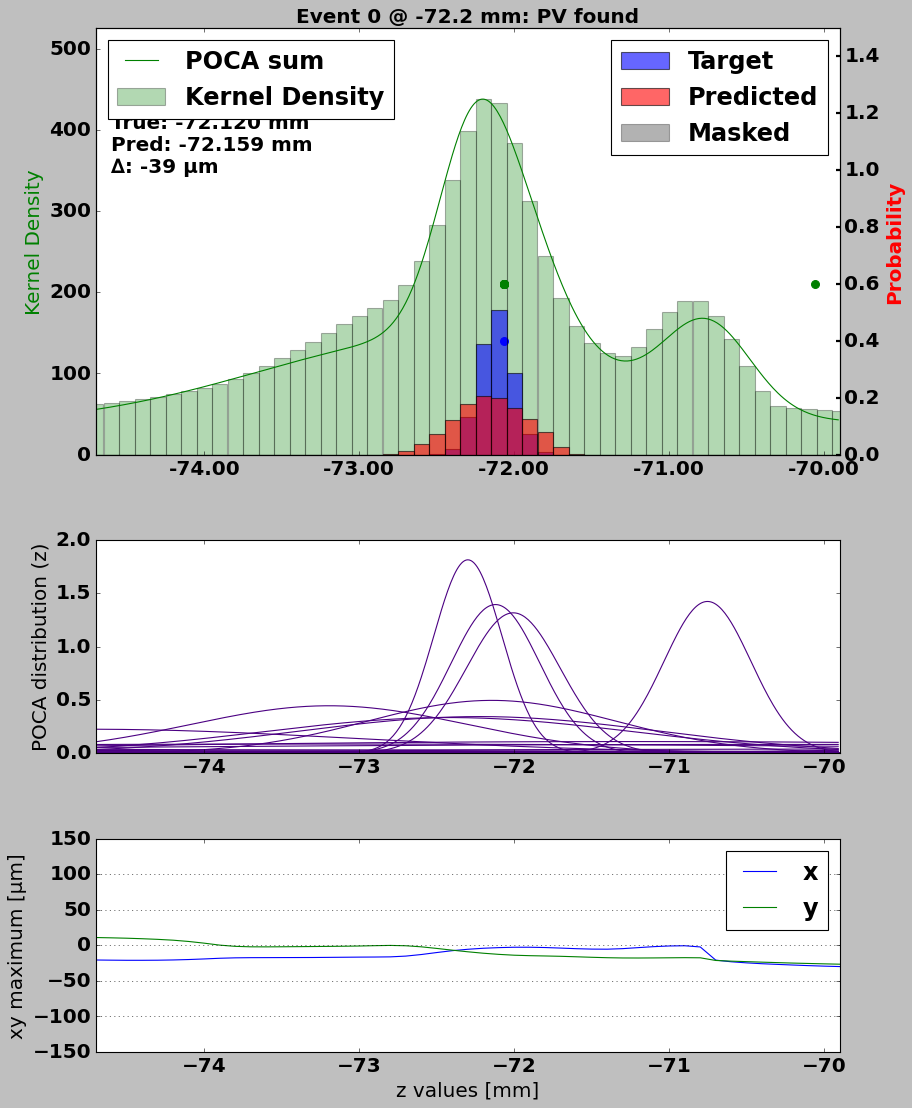

min_z =  -74.7
max_z =  -69.9


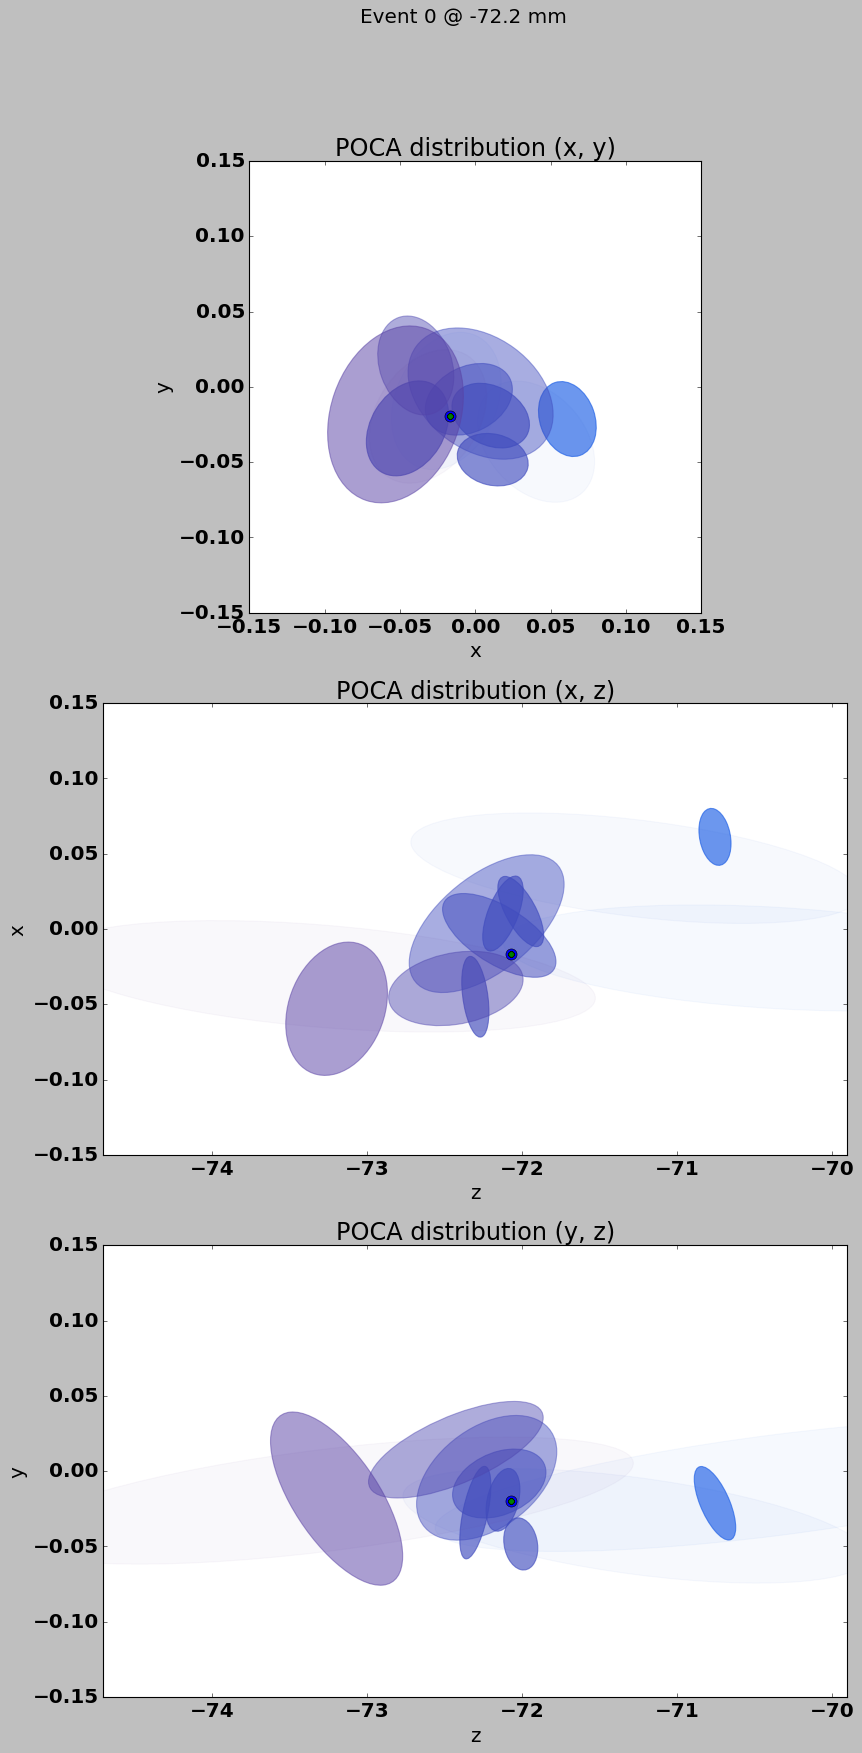


Event 0.1:


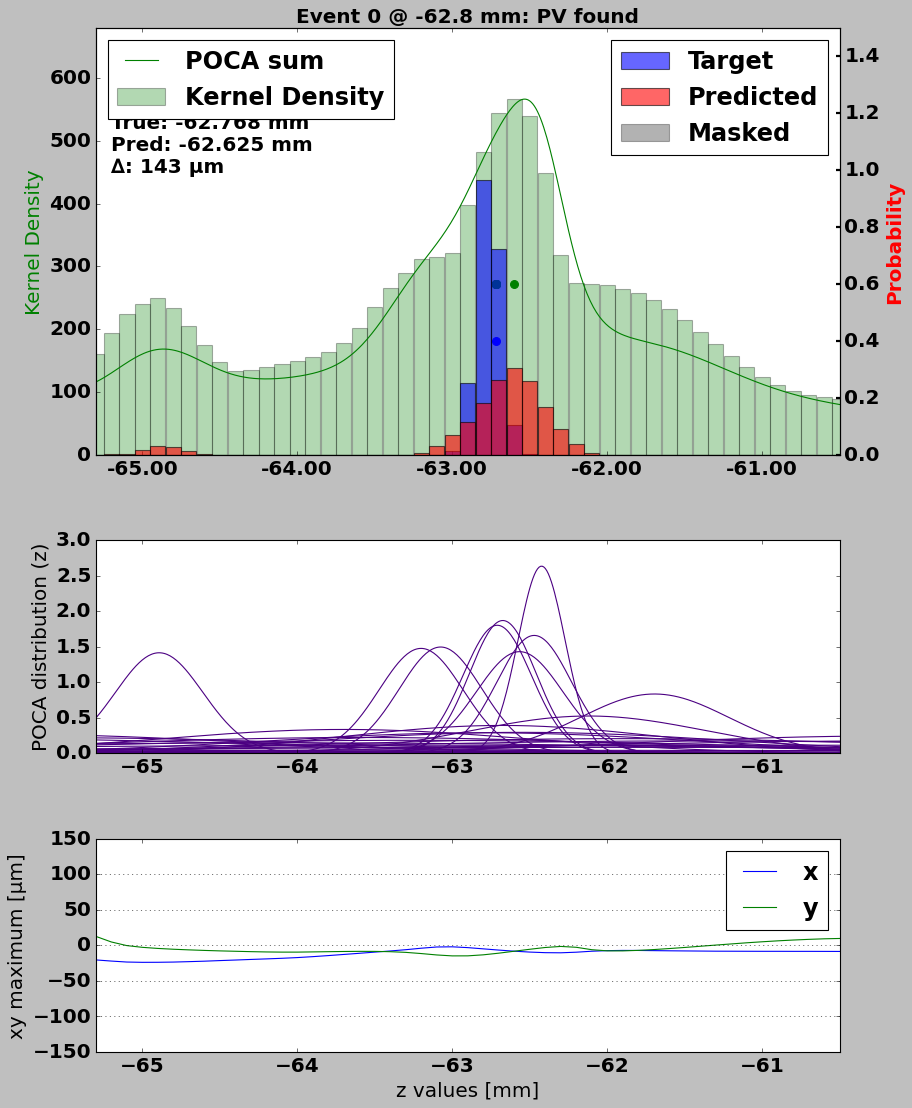

min_z =  -65.3
max_z =  -60.49999999999999


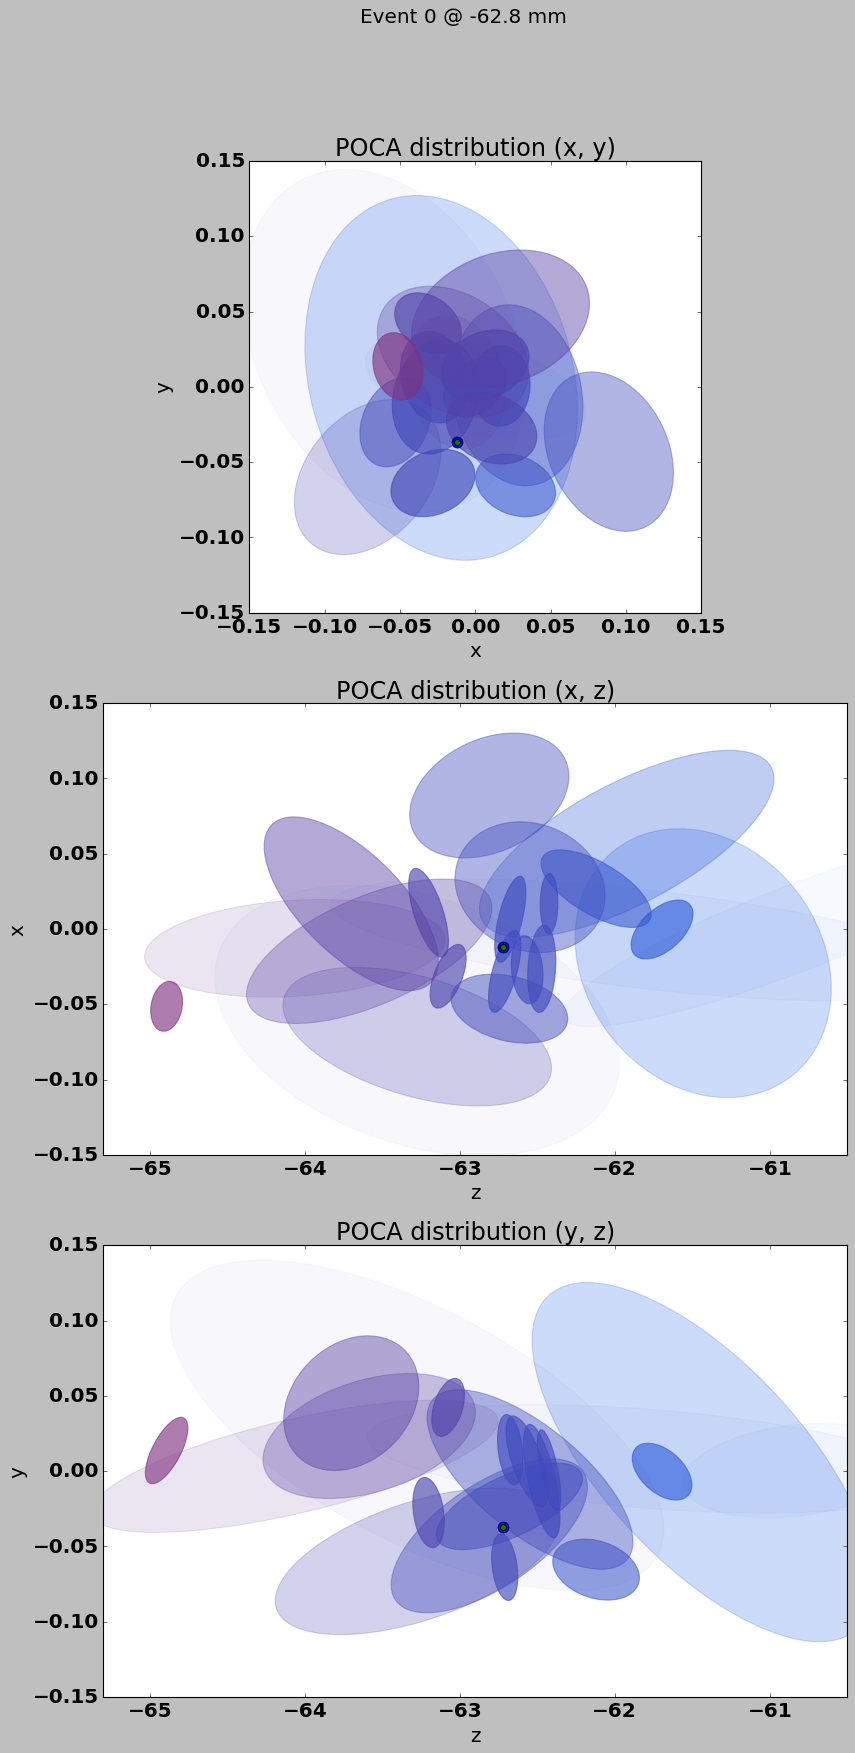


Event 0.2:


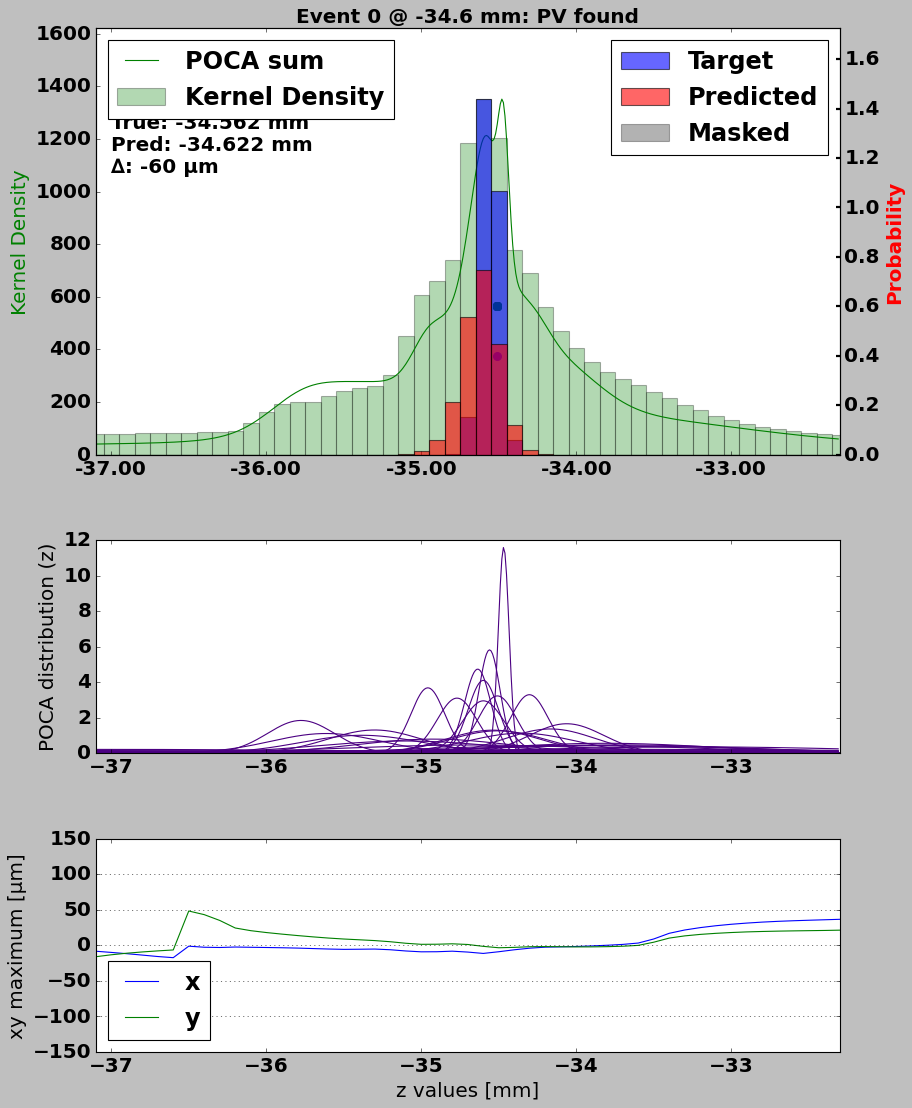

min_z =  -37.1
max_z =  -32.300000000000004


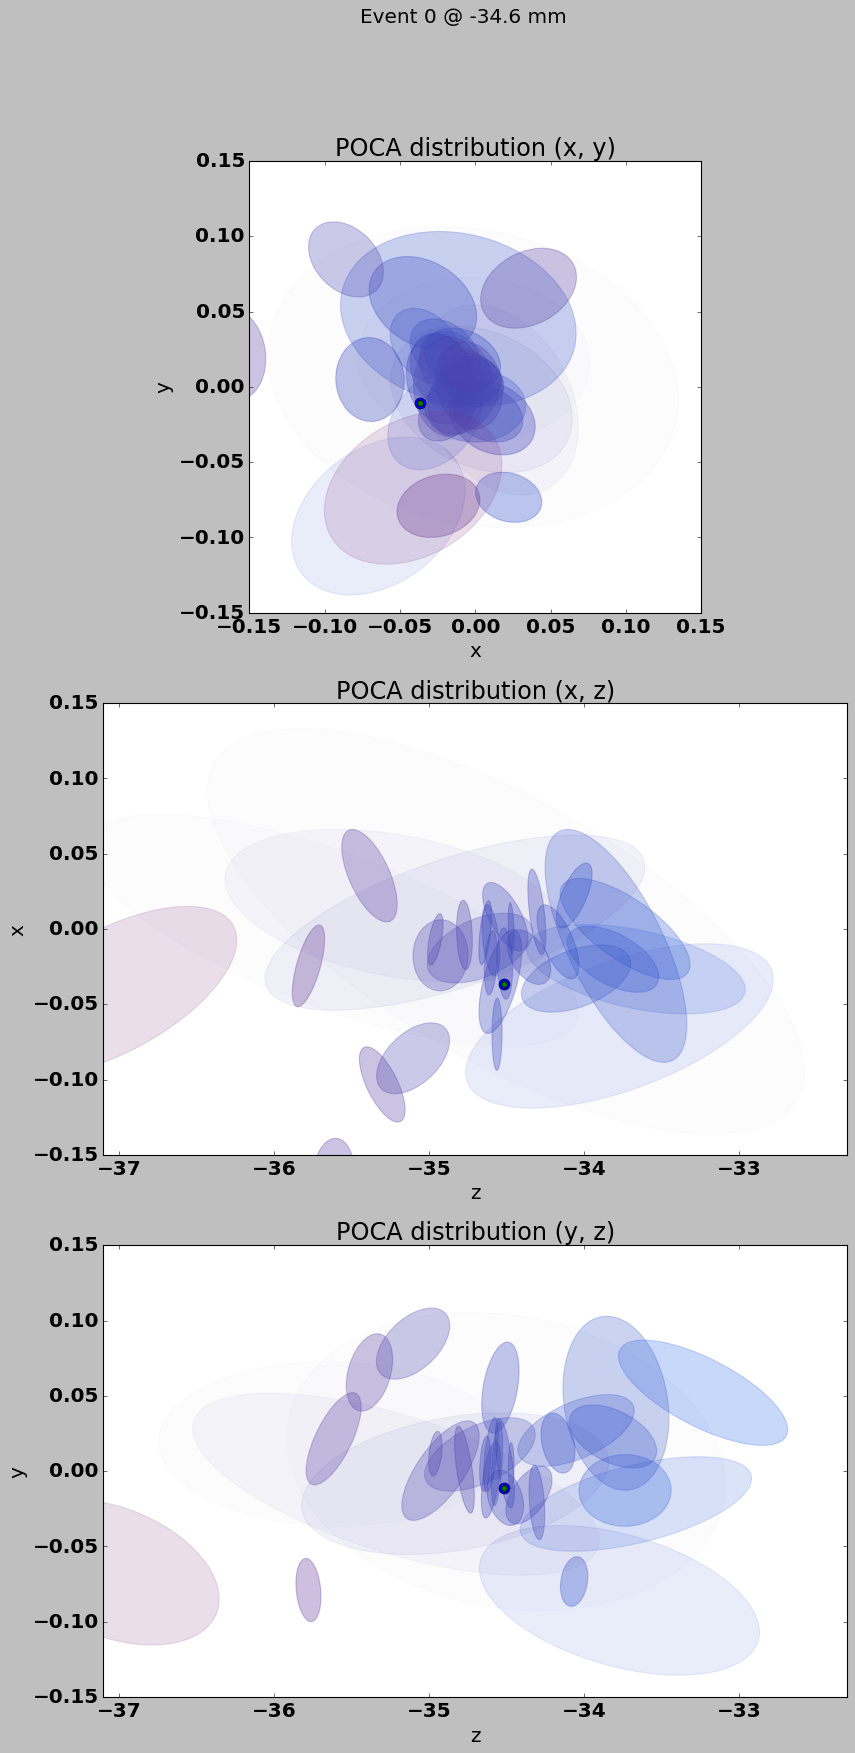


Event 0.3:


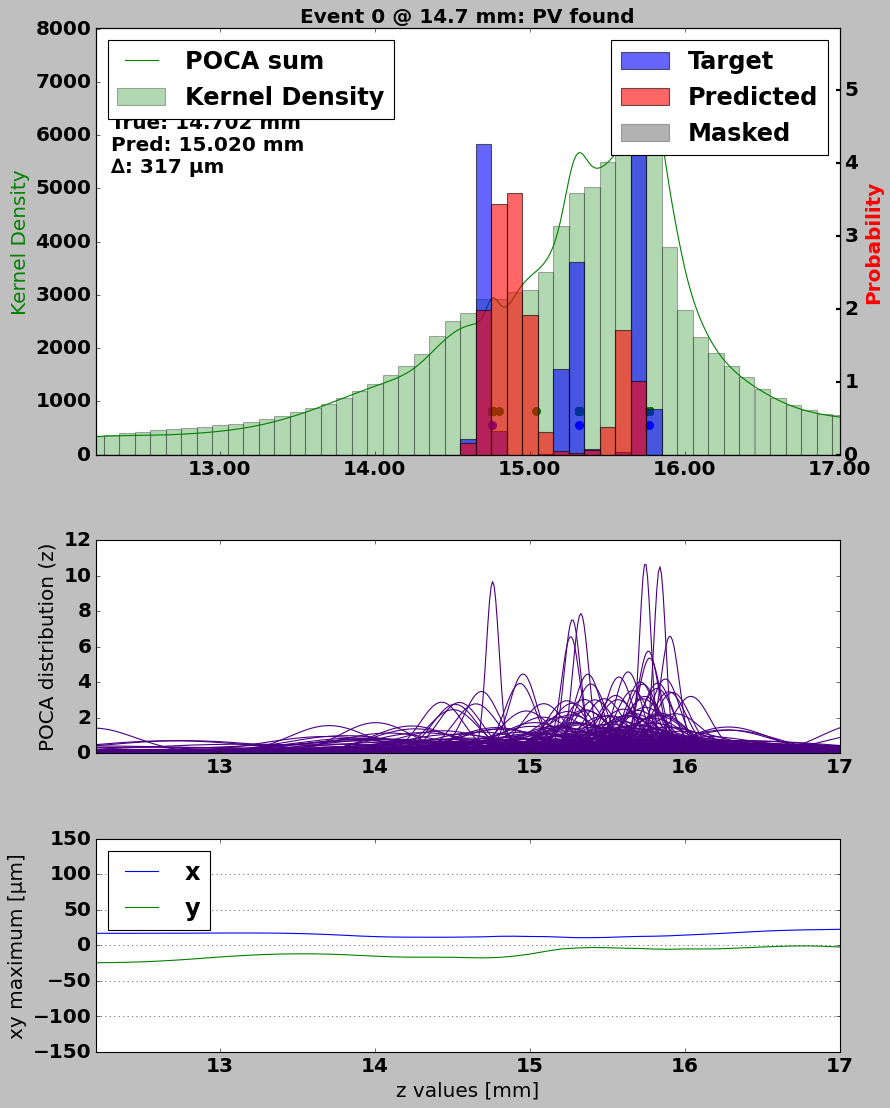

min_z =  12.2
max_z =  17.0


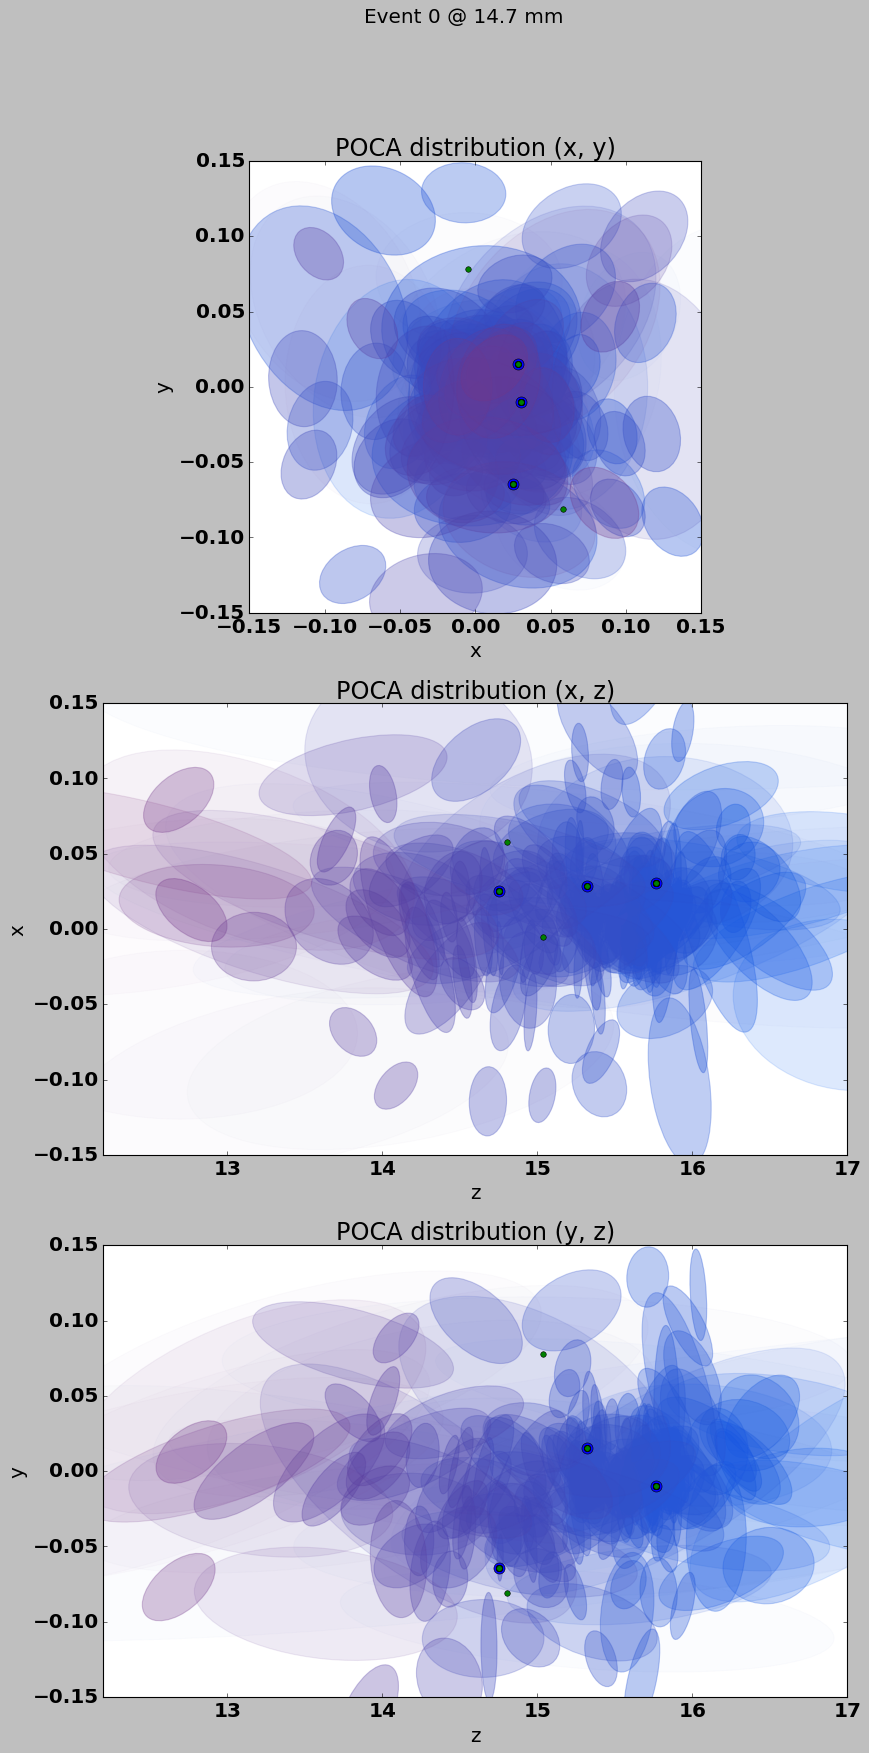


Event 0.4:


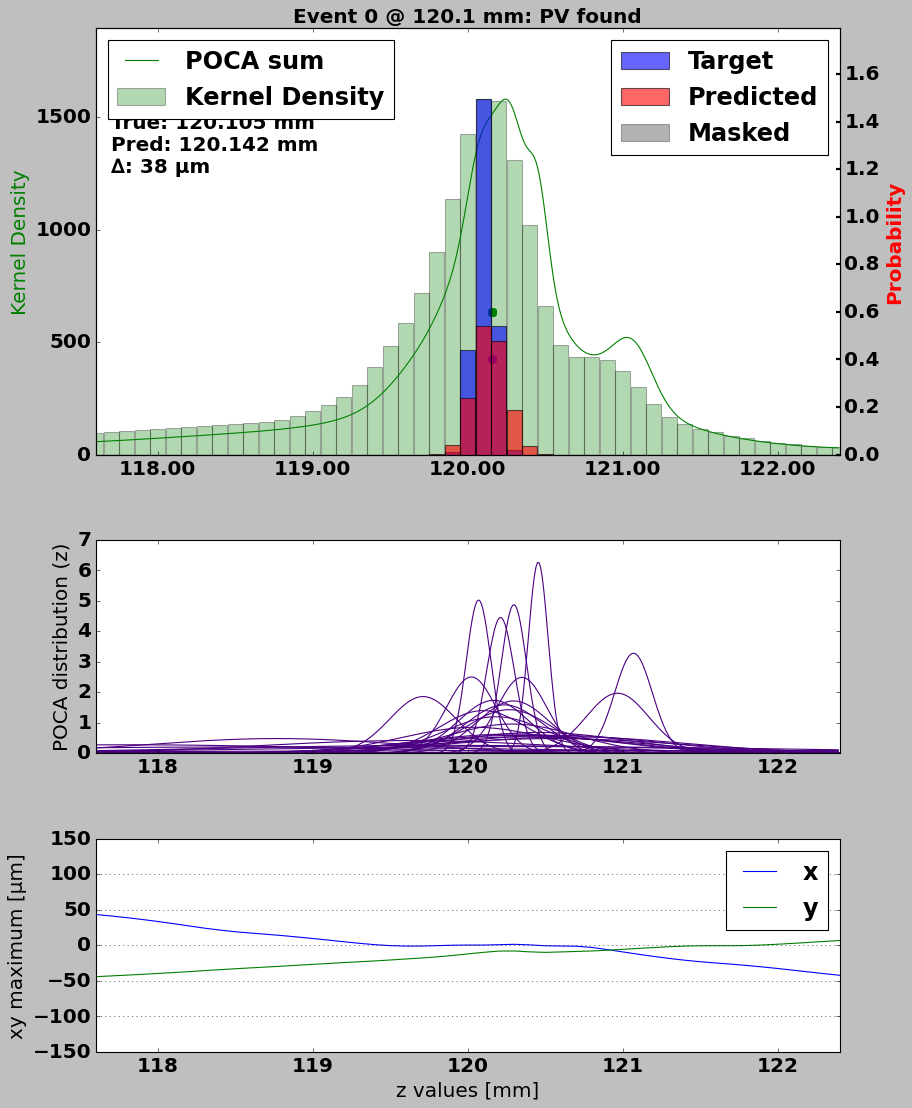

min_z =  117.6
max_z =  122.39999999999999


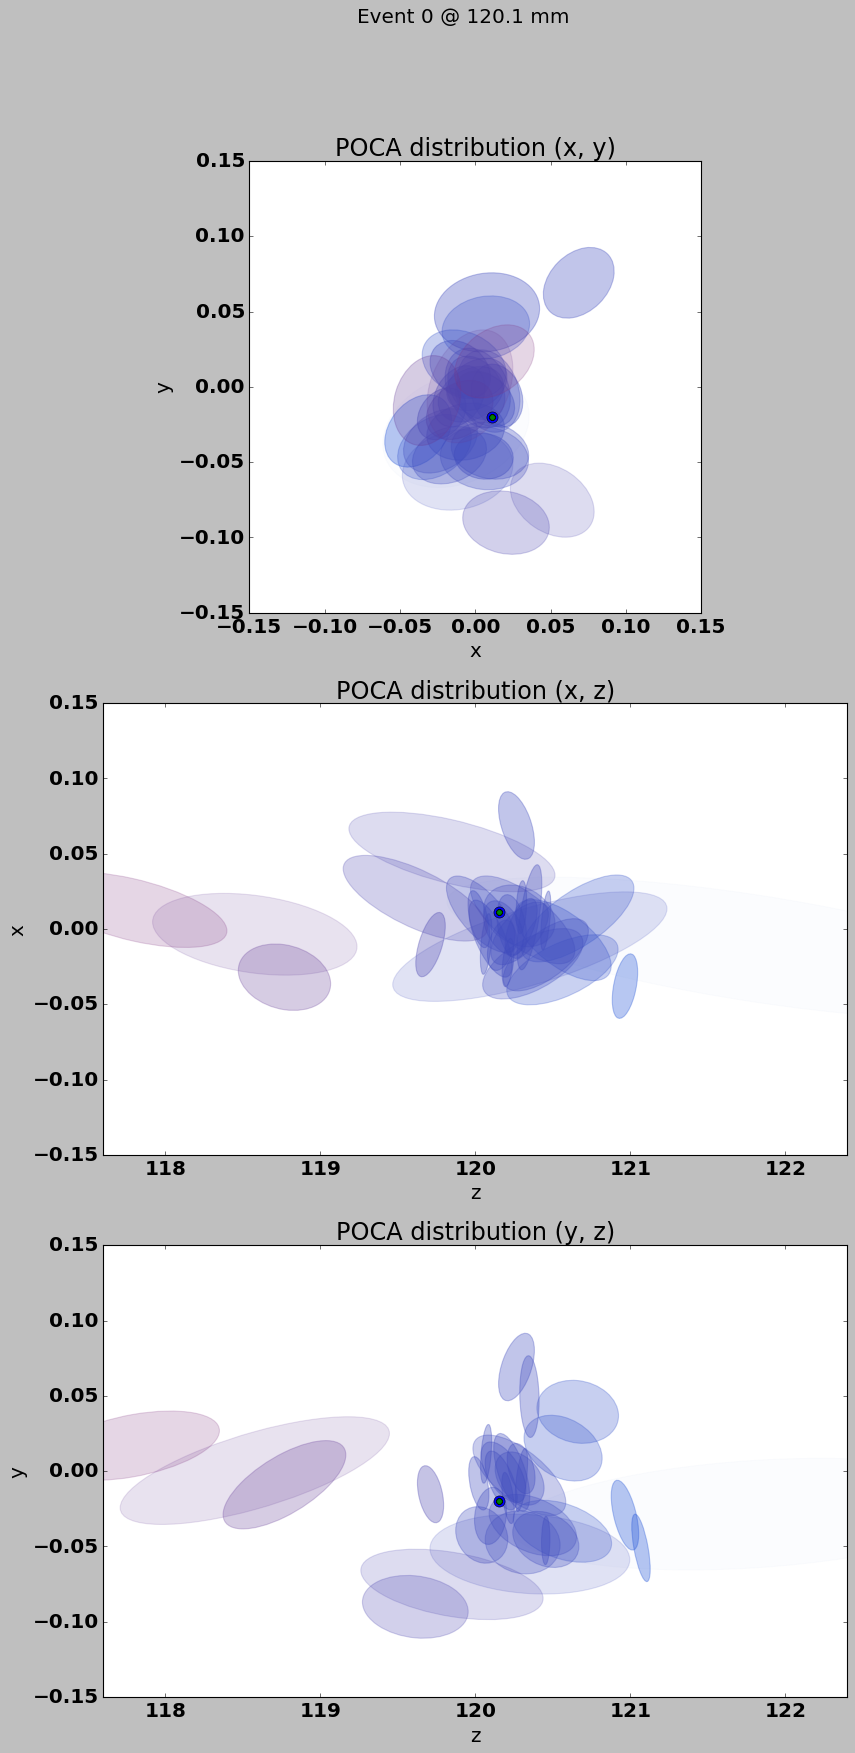


Event 1: Found 8 of 8, added 0 (eff 100.00%)

Event 1.0:


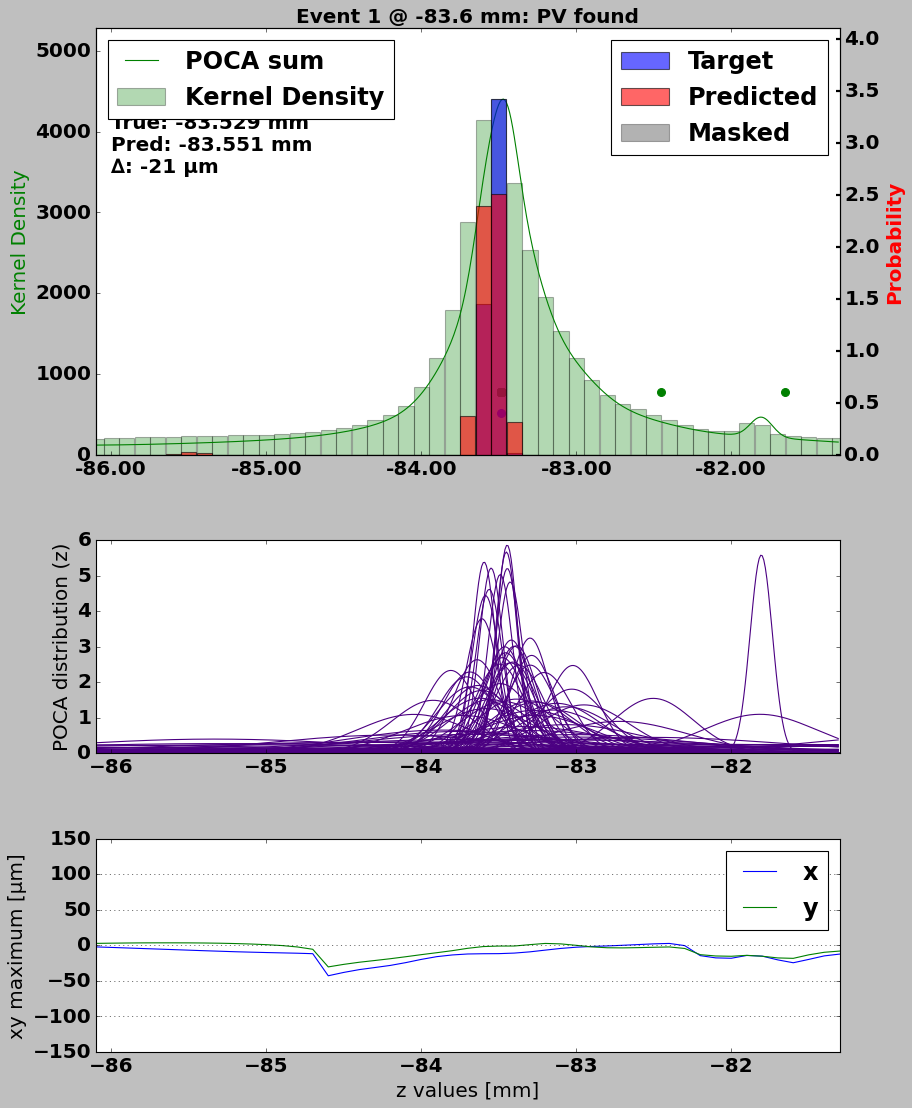

min_z =  -86.1
max_z =  -81.3


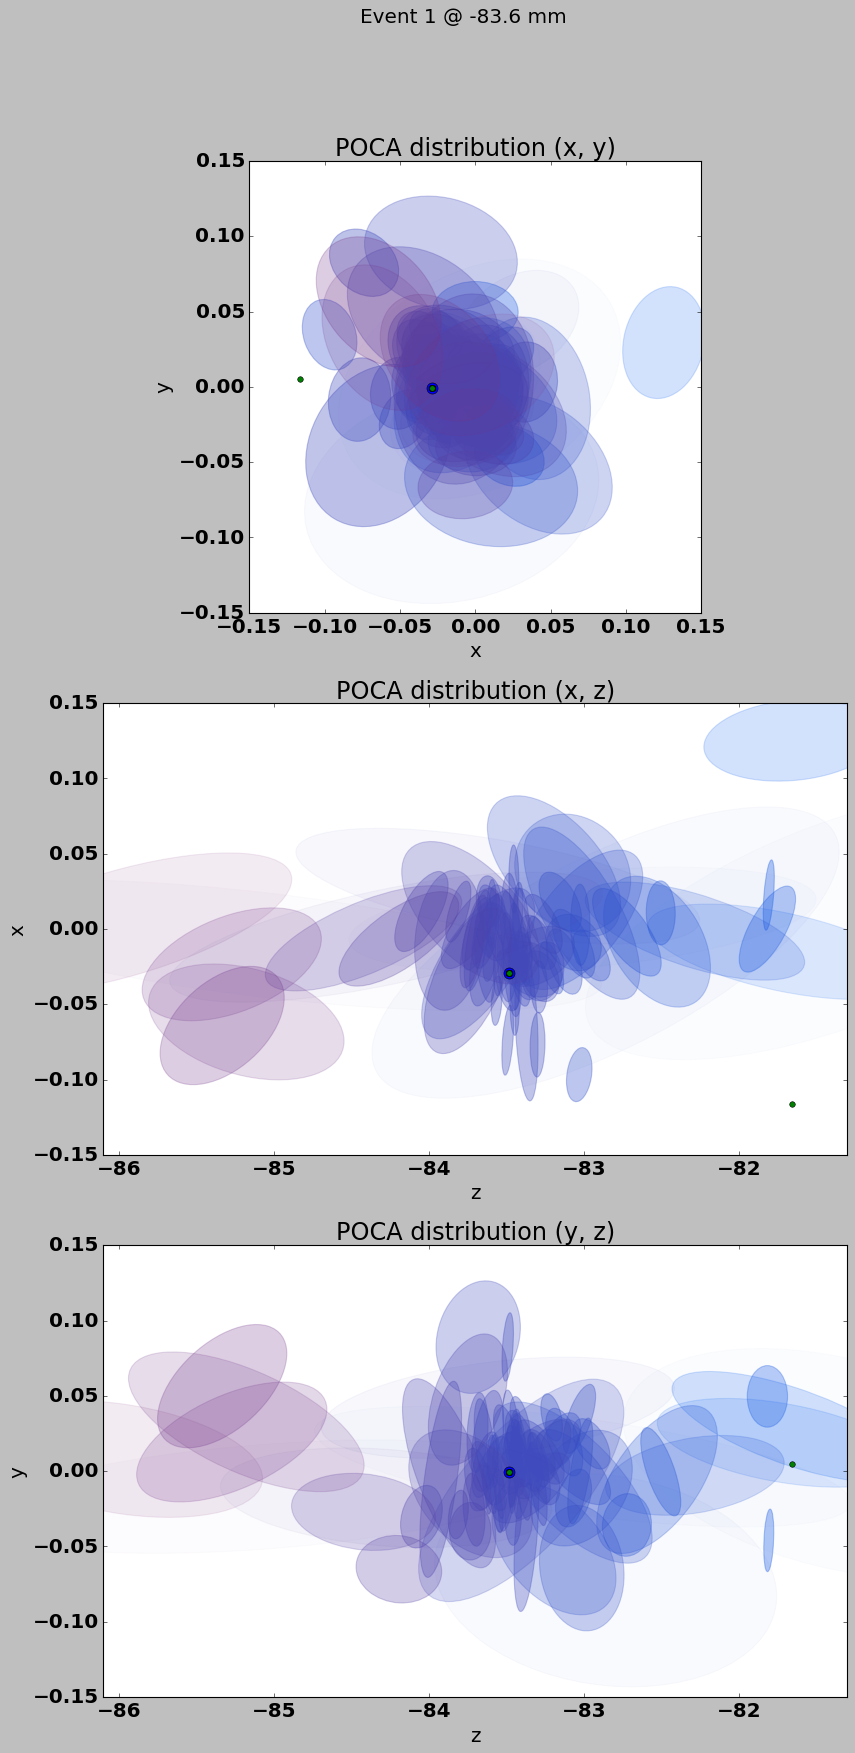


Event 1.1:


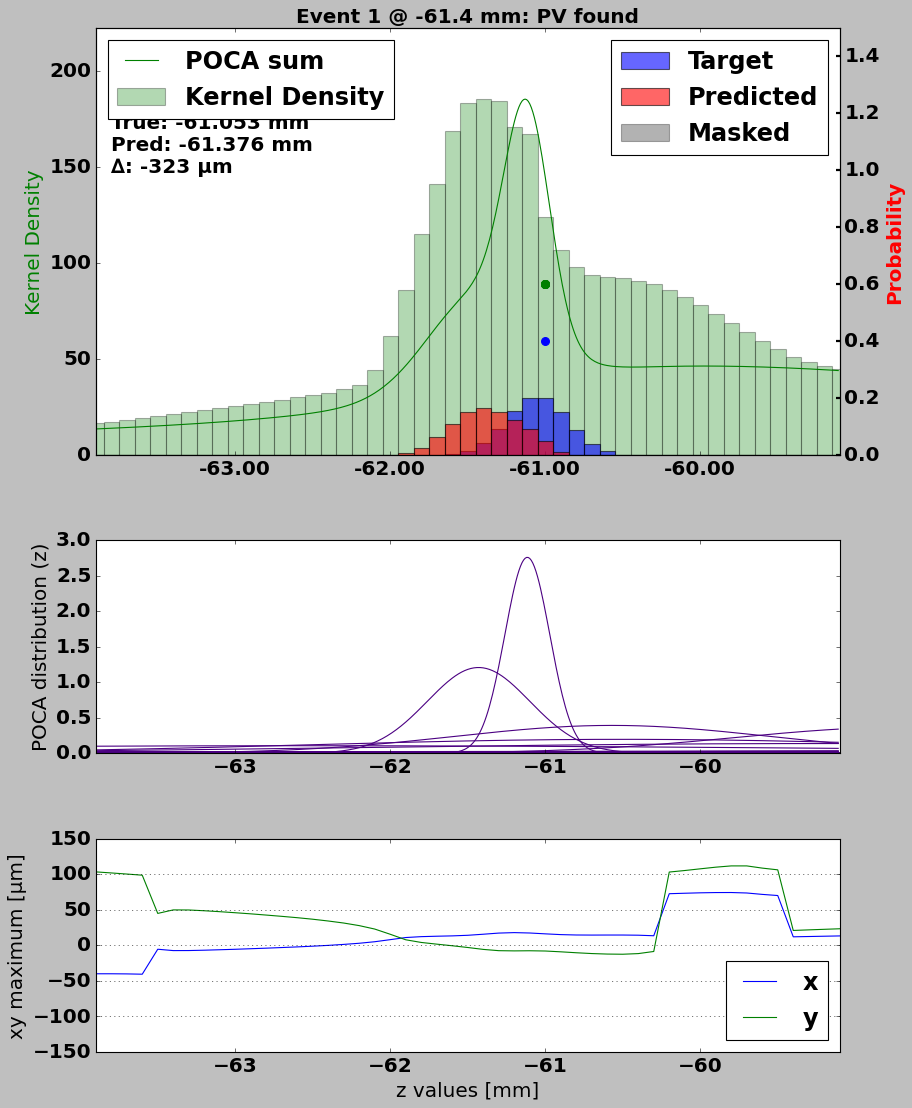

min_z =  -63.9
max_z =  -59.1


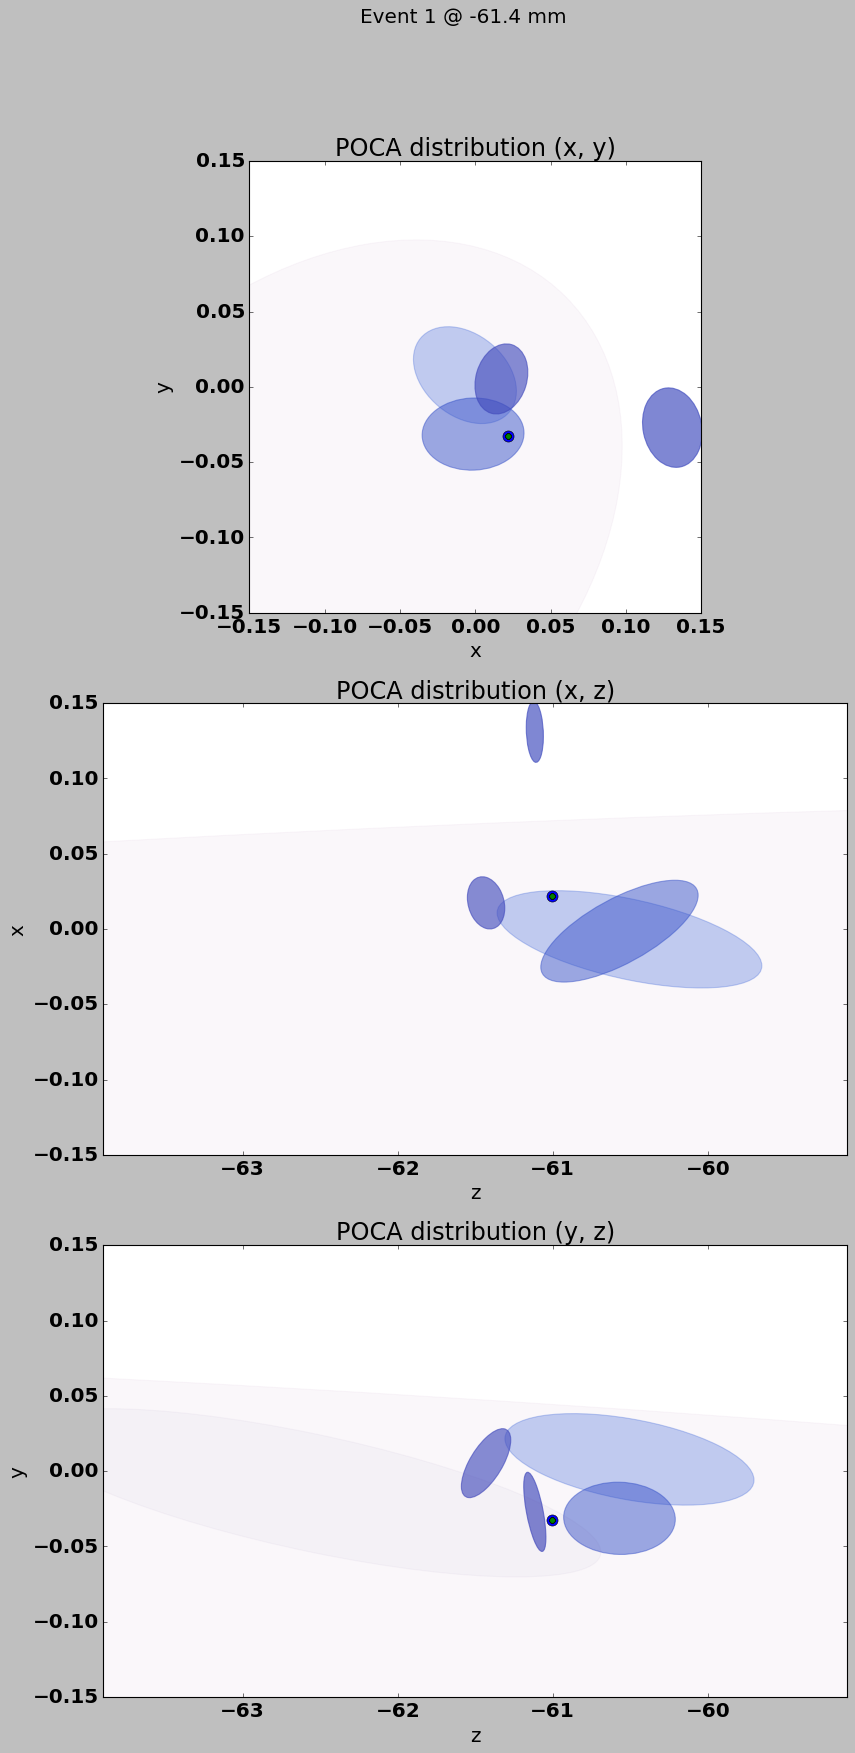


Event 1.2:


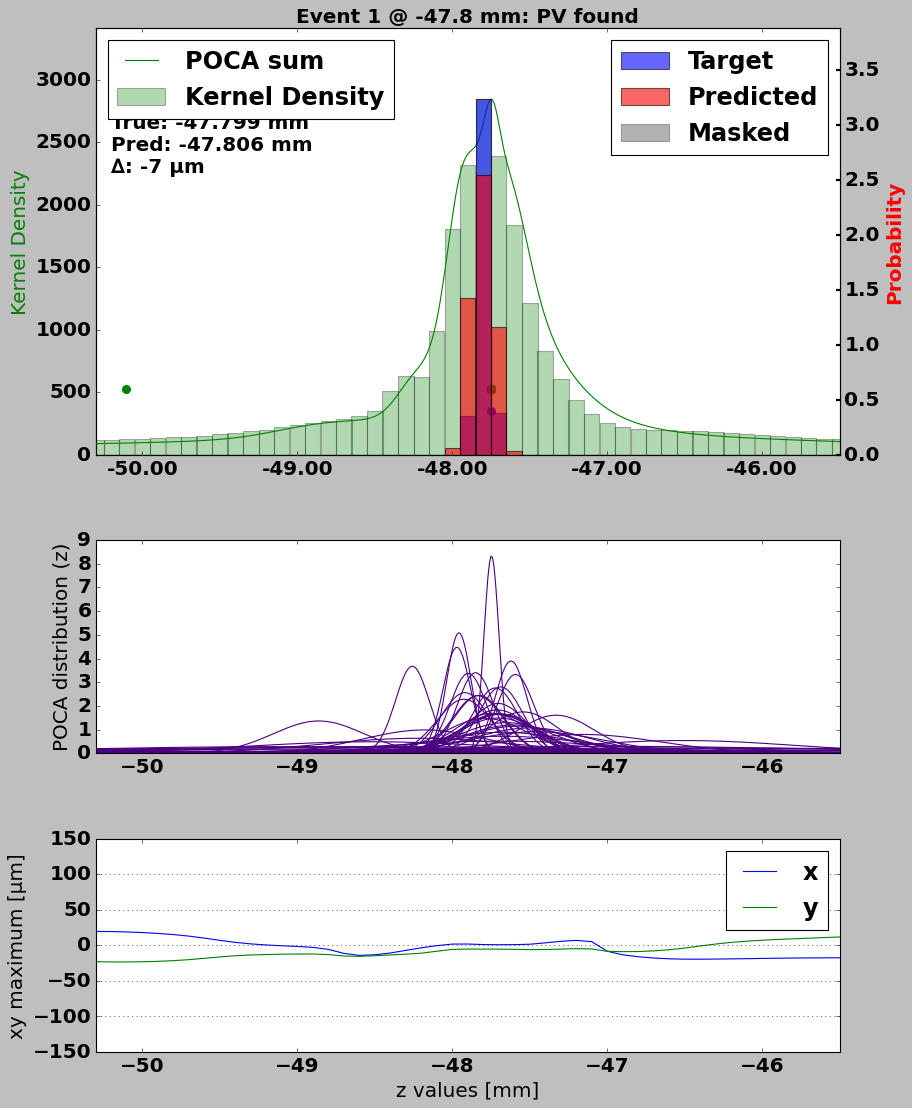

min_z =  -50.3
max_z =  -45.49999999999999


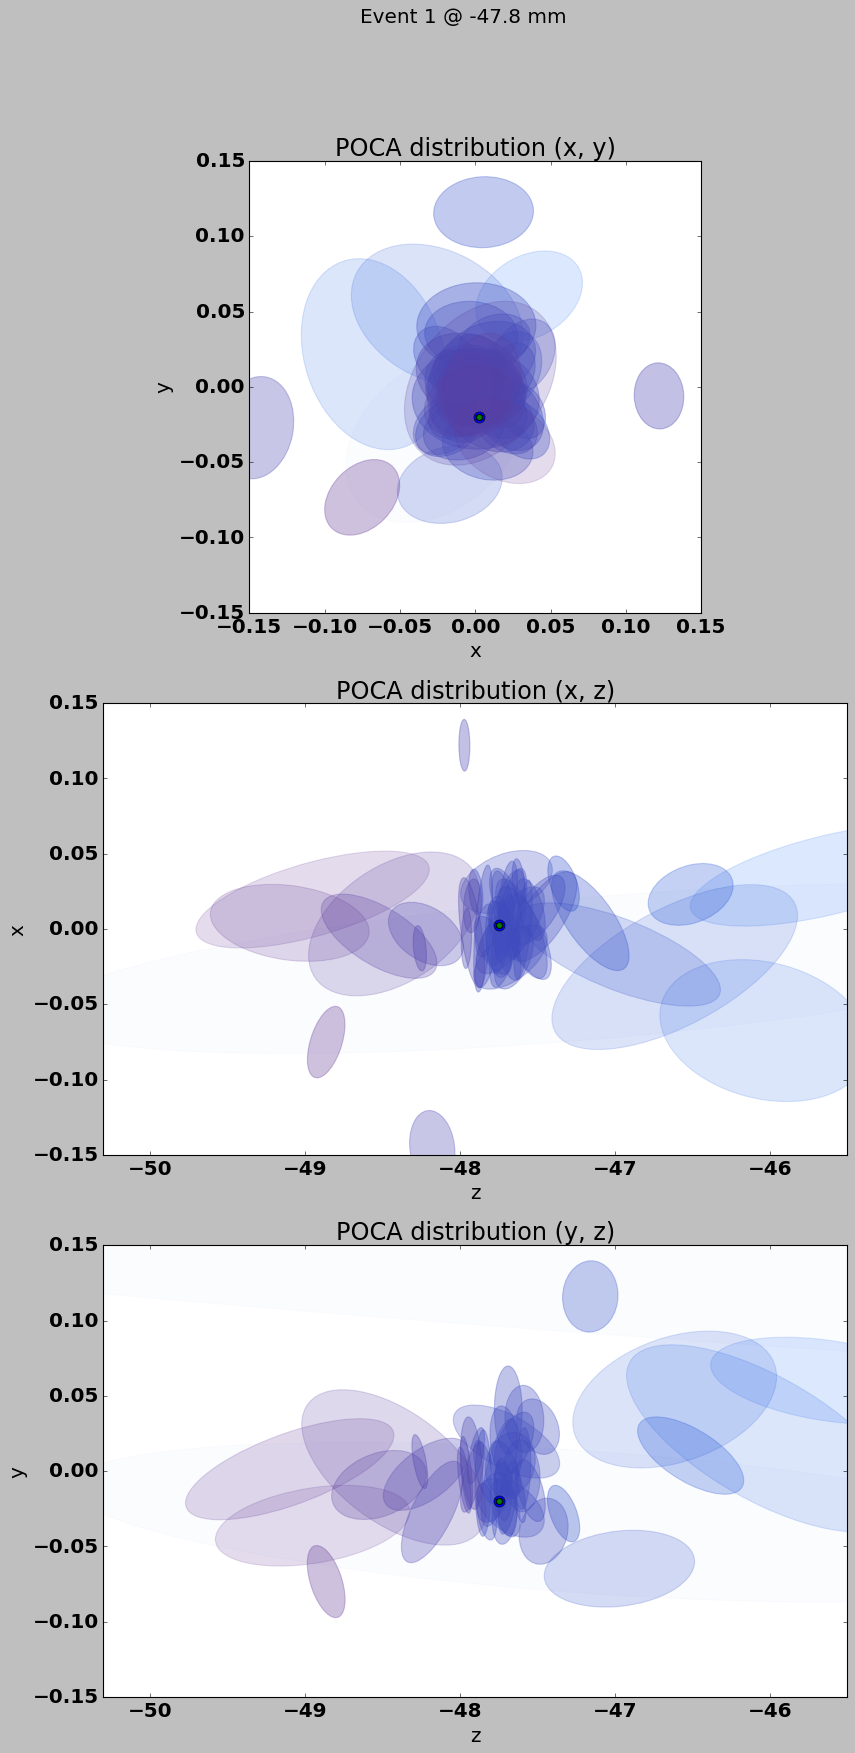


Event 1.3:


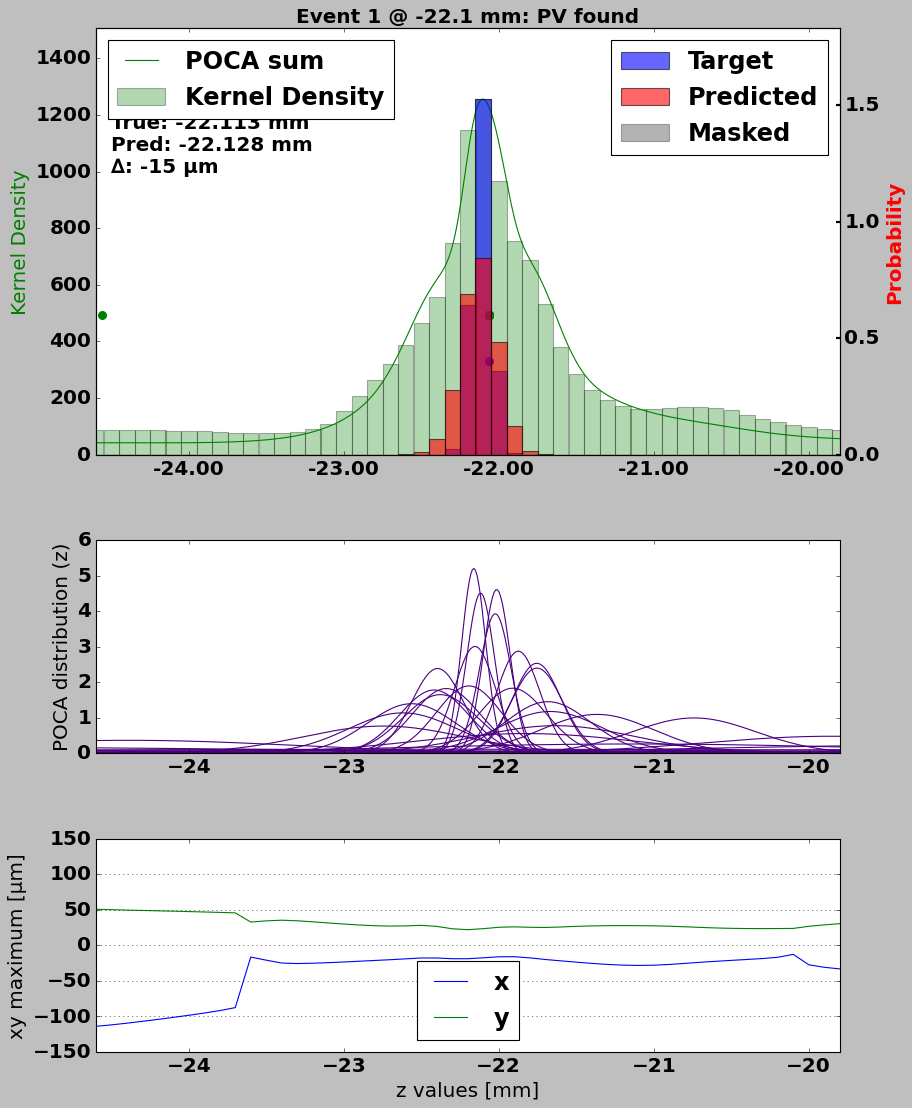

min_z =  -24.6
max_z =  -19.8


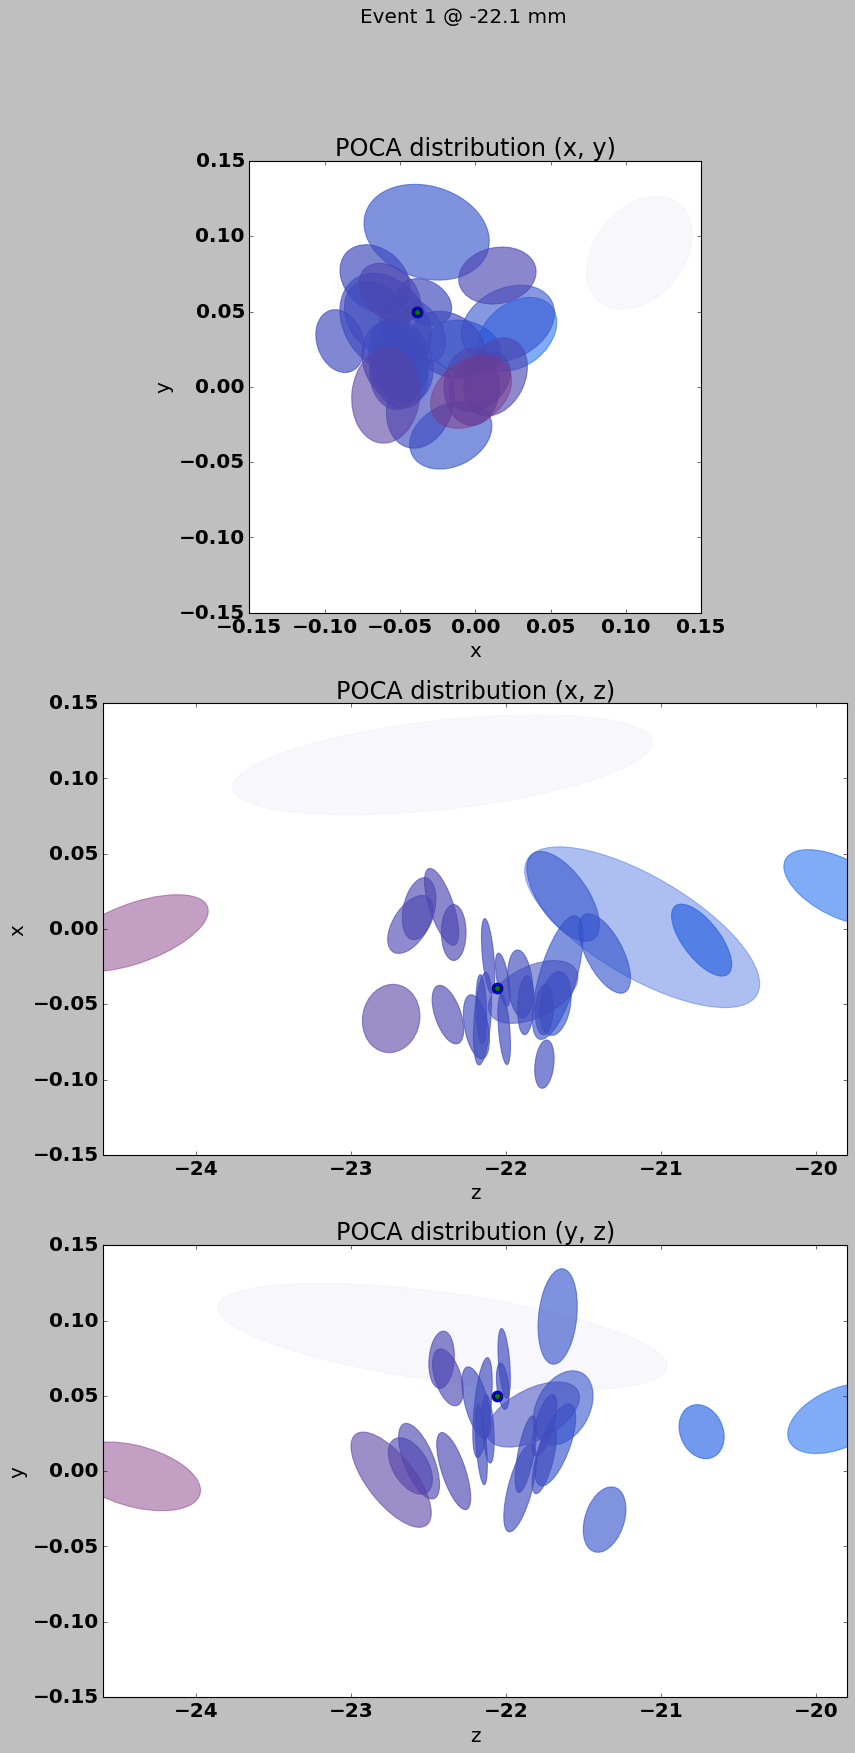


Event 1.4:


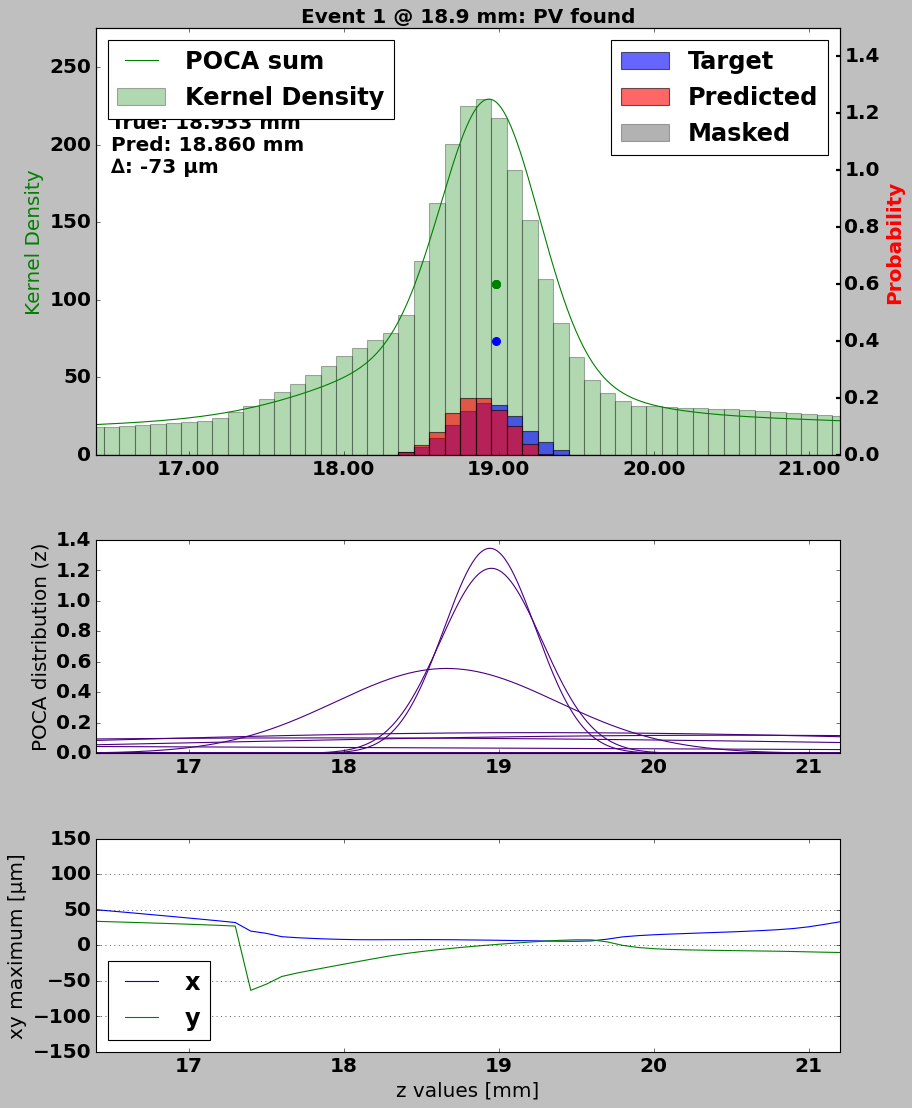

min_z =  16.4
max_z =  21.2


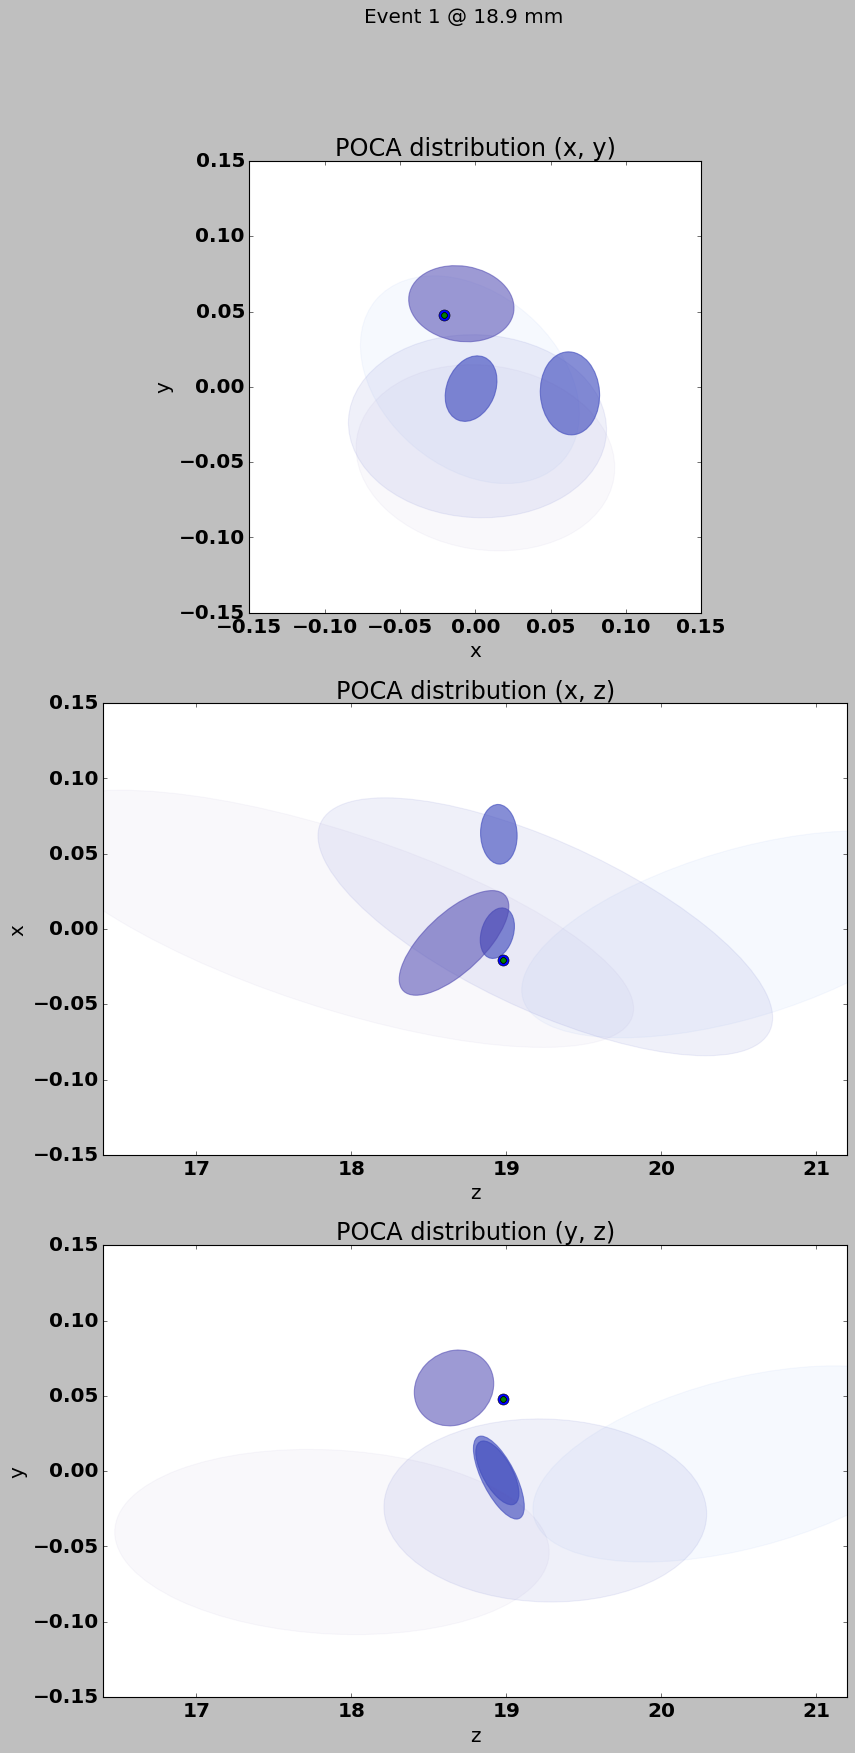


Event 1.5:


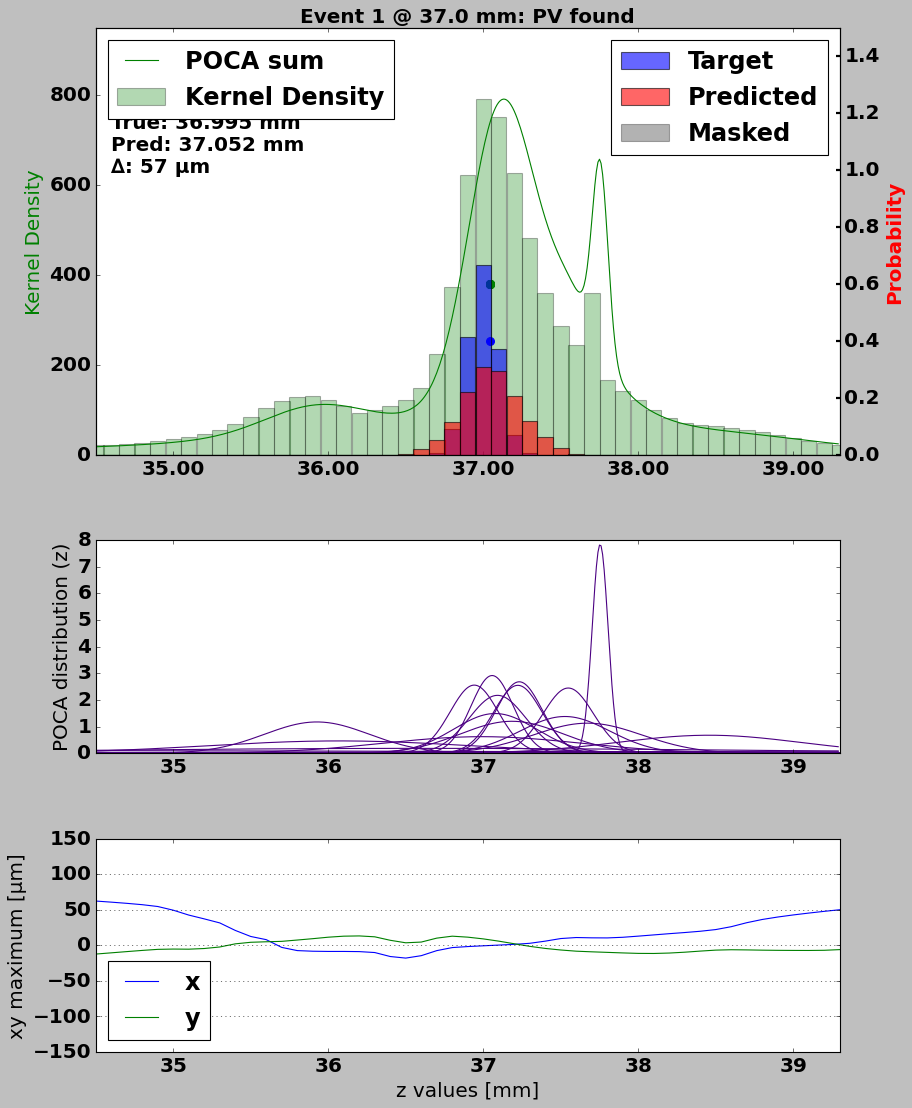

min_z =  34.5
max_z =  39.3


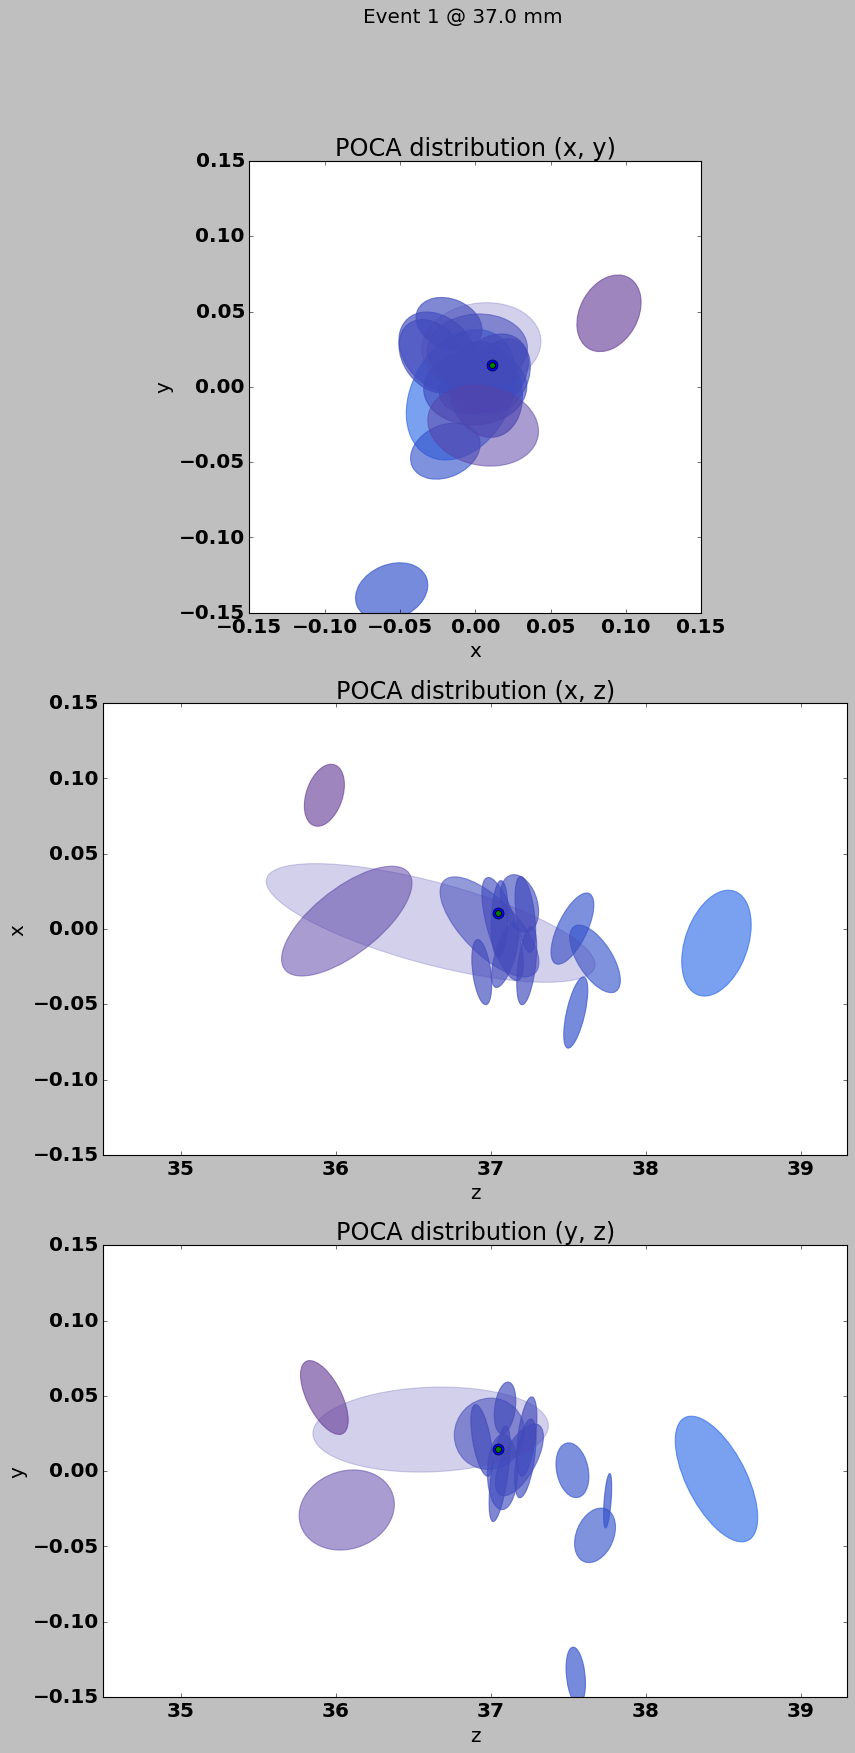


Event 1.6:


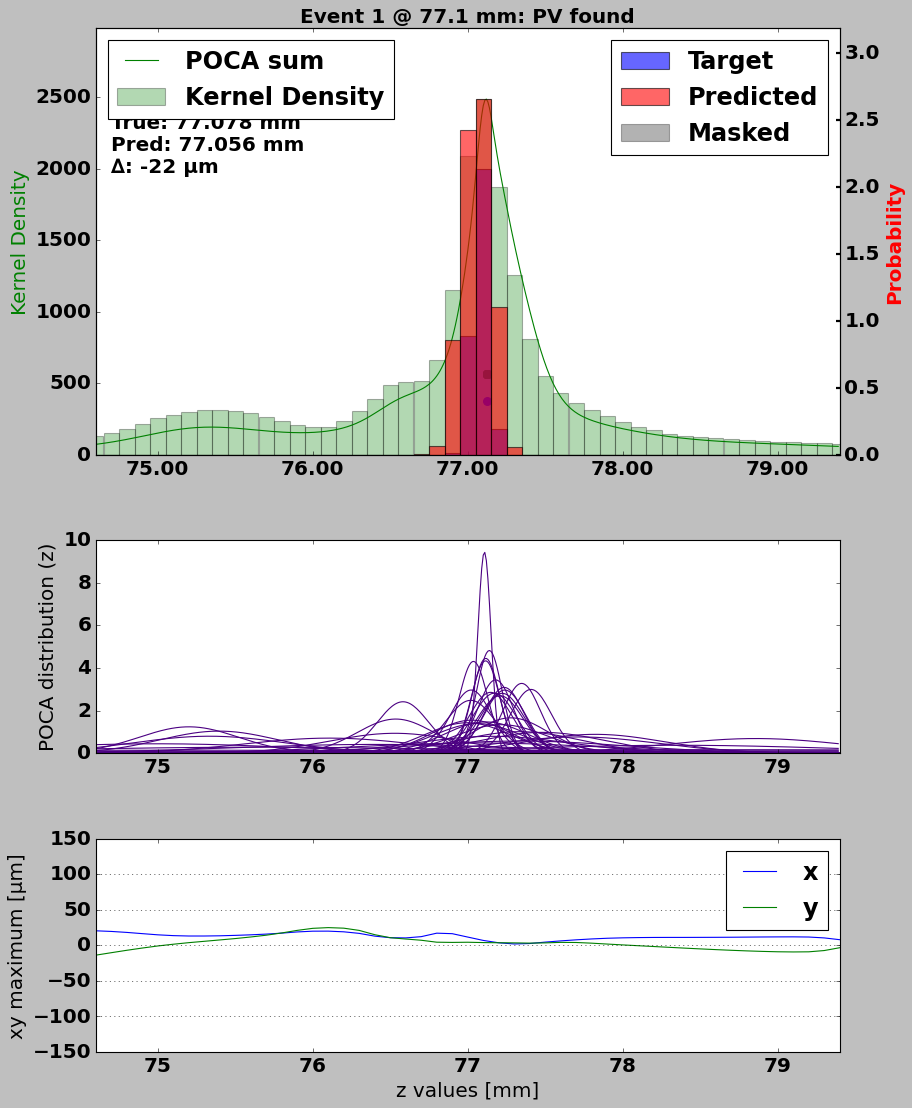

min_z =  74.6
max_z =  79.39999999999999


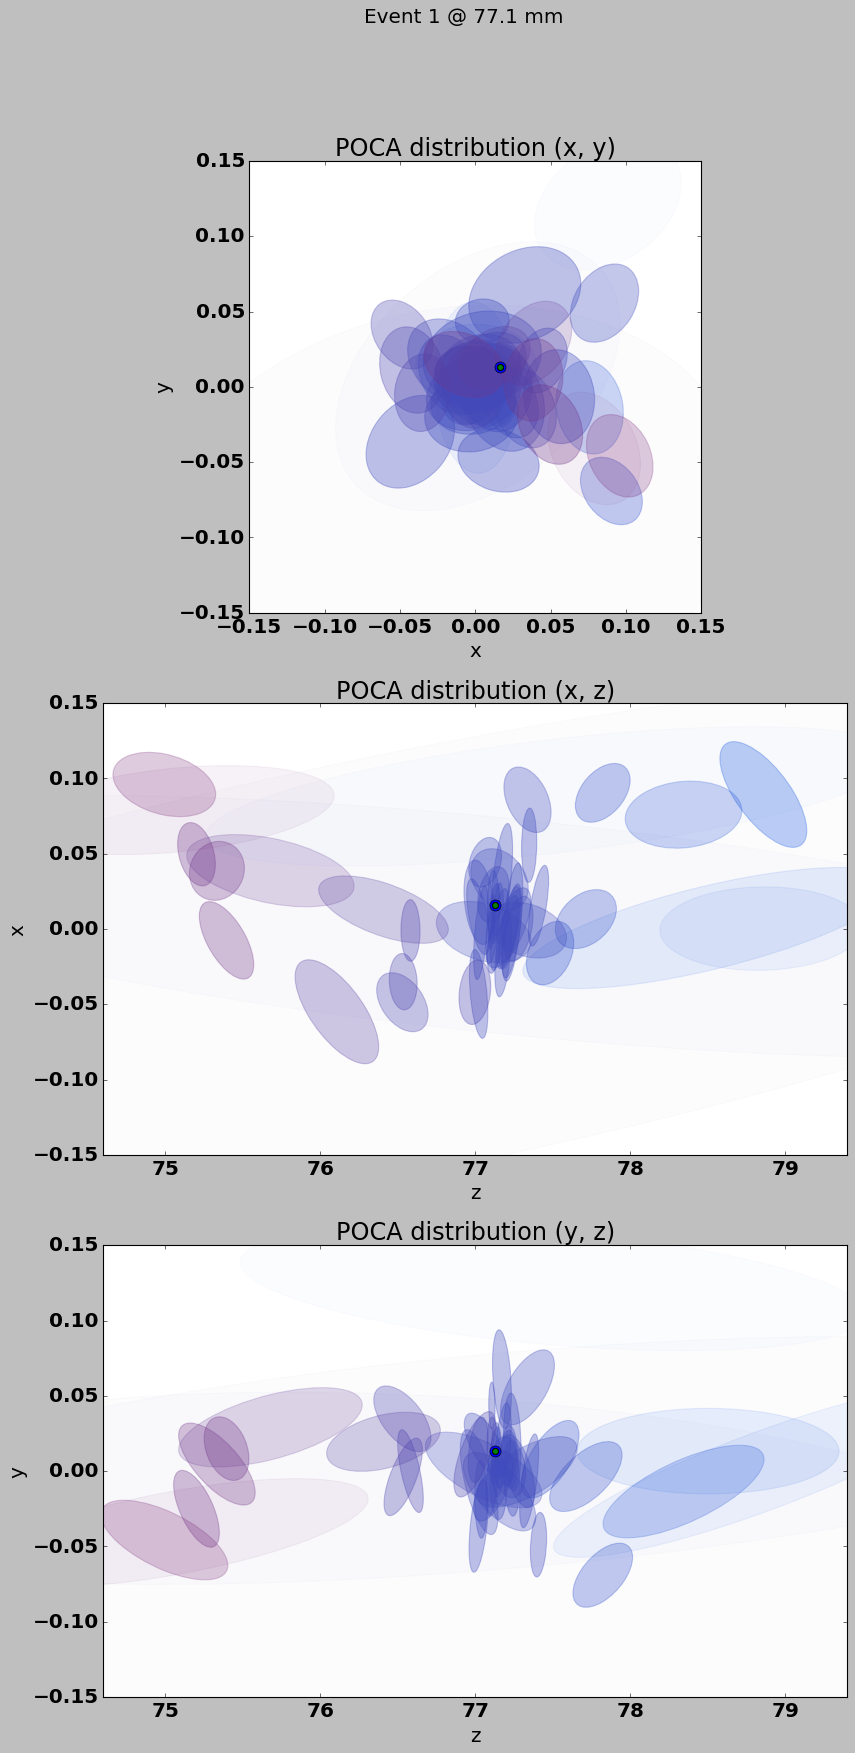


Event 1.7:


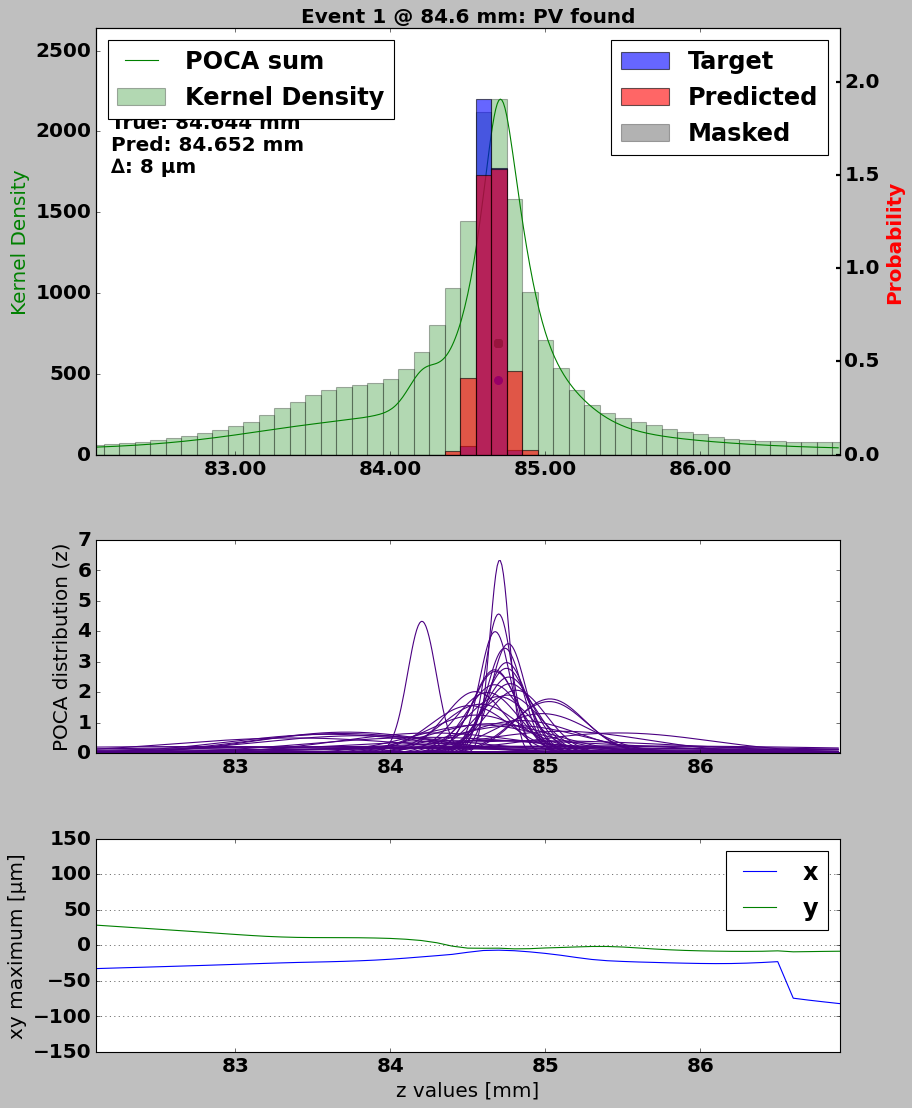

min_z =  82.1
max_z =  86.89999999999999


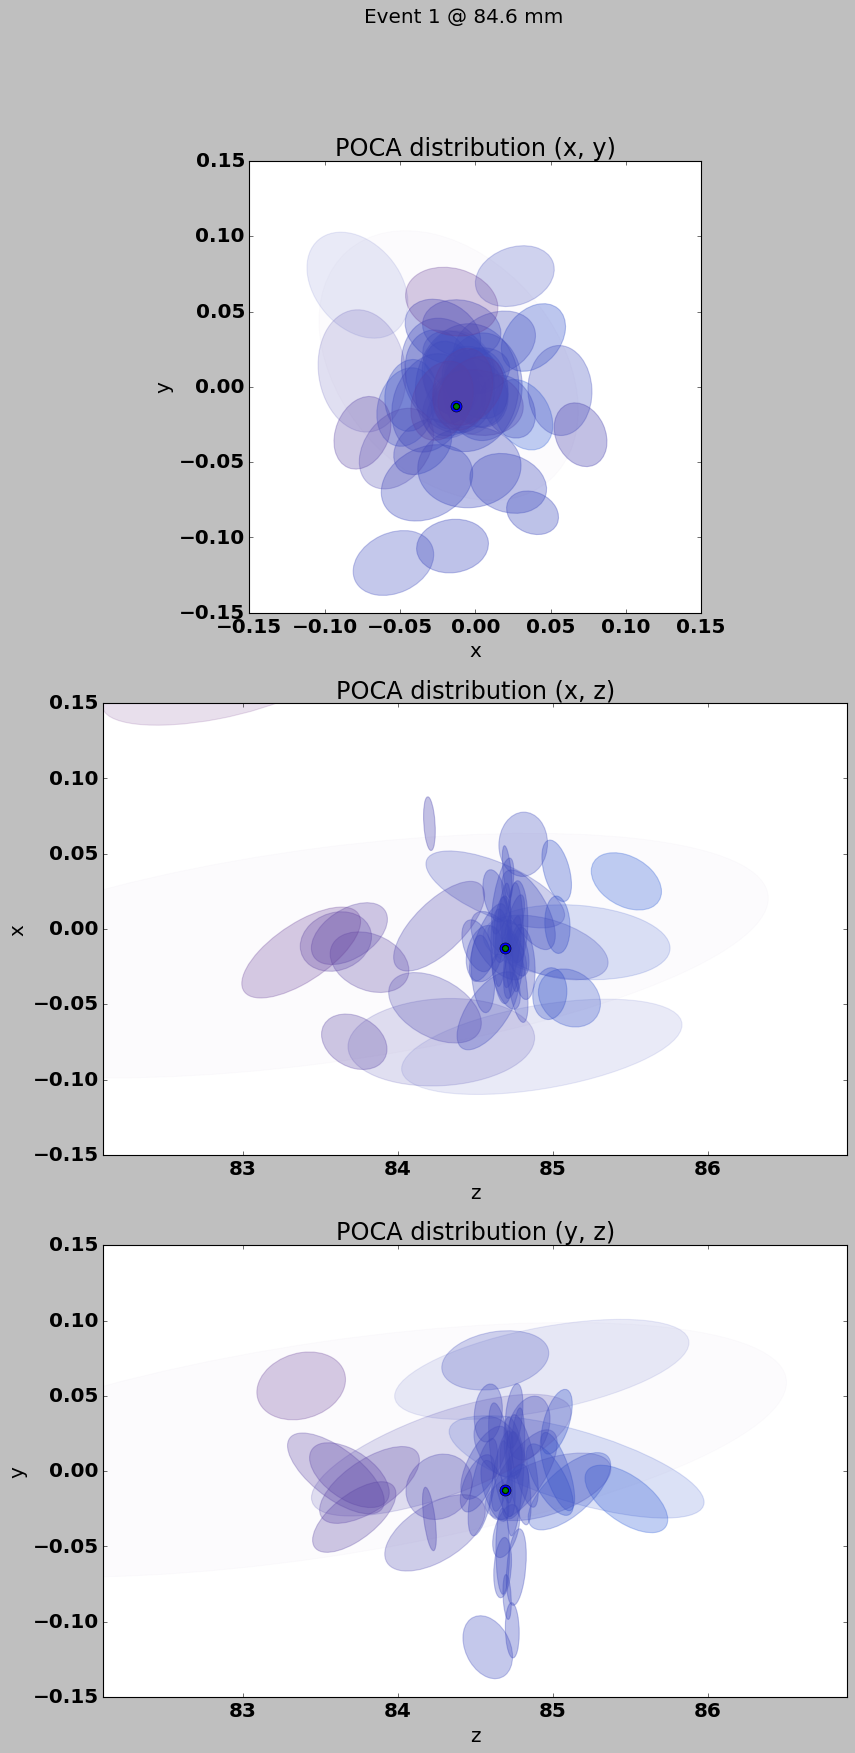

Event 0: Found 6 of 7, added 0 (eff 85.71%)
Event 1: Found 8 of 8, added 0 (eff 100.00%)



In [14]:
inputs = validation.dataset.tensors[0].cpu().numpy()[:,0,:]
zvals = np.linspace(-100, 300, 4000, endpoint=False) + 0.05
finalmsg = ''
internal_count = 0
output_filename = None # Or set: '120000_3layer_{number:02}.pdf'

min_z_vals = []
max_z_vals = []

# plot for 100 events
for event in range(2):
    
    #assign current input, label, and output for event
    input = inputs[event]
    label = labels[event]
    output = outputs[event]
    
    # Consistent parameters for the calls below
    parameters = {
        "threshold": 1e-2,
        "integral_threshold": .2,
        "min_width": 3
    }
    
    # Compute the "actual" efficencies and things
    ftruth = pv_locations(label, **parameters)
    fcomputed = pv_locations(output, **parameters)
    results = efficiency(label, output, difference=5.0, **parameters)
    
    # Add a line to the final results string (print at end)
    finalmsg += f"Event {event}: {results}\n"
    
    # Make sure bin numbers are integers
    truth = np.around(ftruth).astype(np.int32)
    computed = np.around(fcomputed).astype(np.int32)
    
    # Join arrays and remove any points closer than 5 bins
    # We plot over these "points of interest"
    poi = np.sort(np.concatenate([truth, computed]))
    poi = poi[np.concatenate([[True], np.fabs(np.diff(poi)) > 5])]
    
    print(f"\nEvent {event}:", results)
    
    for index, i in enumerate(poi):
        # Convert to location in z
        center = (i / 10) - 100
        
        # Collect items less than 5 apart as "true"
        b_truth = np.fabs(ftruth - i) <= 5
        b_comp = np.fabs(fcomputed - i) <= 5
        in_truth = np.any(b_truth)
        in_comp = np.any(b_comp)
        
        if in_truth and in_comp:
            msg = 'PV found'
        elif in_truth:
            msg = 'PV not found'
        elif False:
            pass # Check for NaNs
        else:
            msg = 'False positive'
            
        with plt.style.context({
            'font.size':18,
            'font.weight':'bold'}):
            
            #specify subplot information (3 subplots)
            fig, axs = plt.subplots(3, figsize=(12,16),
                                    gridspec_kw={'height_ratios':[2,1,1], 'hspace':0.3})
        
            #bins for plot_ruiplot (needed to find min/max for first axis)
            x_bins = np.round(zvals[i - 25 : i + 25] - 0.05, 2)
        
        
            ##############################
            #plot POCA z (second subplot)#
            ##############################
            
            #specify second axis for subplot
            ax_poca = axs[1]
            #calculate width of bins and subtract to make sure that our domain ends up correct
            width = x_bins[1]-x_bins[0]
            ax_poca.set_xlim([min(x_bins), max(x_bins)-width])
            
            #create array to plot POCA-ellipsoid Gaussians
            pocavals = np.arange(min(x_bins),max(x_bins)-(x_bins[1]-x_bins[0]),0.01)
            
            ax_poca.set_ylabel('POCA distribution (z)')
            #initialize sum of POCA gaussians (sum used in subplot 1)
            sum_poca = np.zeros(len(pocavals))
            #iterate through tracks, evaluate Gaussian over range pocavals, add to sum_poca, plot current poca-gaussian
            #note: Gaussians are scaled to unit area, width corresponds to the width of the major axis in the z-dir
            for j in range(len(pocas["z"]["poca"][event])):
                current_gauss = gaussian(pocavals, pocas["z"]["poca"][event][j], pocas["z"]["major_axis"][event][j])
                sum_poca = np.add(sum_poca, current_gauss)
                ax_poca.plot(pocavals, current_gauss, color = 'indigo')
        
        
            ####################################################
            #plot KDE, target, prediction, etc. (first subplot)#
            ####################################################
            
            # ax1 is the axis that is tied to left (density)
            # ax2 is the axis that is tied to the right (probability)
            # plot_ruiplot from plots_mdsA_200518 is the same as in plots_mdsA except ykernel is outputted in order to scale the poca sum
            ax1, ax2, ykernel = plot_ruiplot(zvals, i, input, label, output, ax=axs[0])
            ax1.set_title(f"Event {event} @ {center:.1f} mm: {msg}",
                          fontdict={'size':18, 'weight':'bold'})
            # calculate factor with which to scale the poca sum
            factor = max(ykernel)/max(sum_poca)
            # plot the sum of the gaussian poca-ellipsoids
            ax1.plot(pocavals, sum_poca*factor, color = 'g', label = "POCA sum")
            ax1.legend(loc = "upper left")
            ax1.set_xlim(ax_poca.get_xlim())

            msg = ""
            
            #display centroids of truth and prediction and their difference
            truth_centroid = (ftruth[b_truth] / 10) - 100
            for value in truth_centroid:
                msg += f"True: {value:.3f} mm\n"
                
            comp_centroid = (fcomputed[b_comp] / 10) - 100
            for value in comp_centroid:
                msg += f"Pred: {value:.3f} mm\n"
                
            if len(truth_centroid) == 1 and len(comp_centroid) == 1:
                diff = (comp_centroid[0] - truth_centroid[0]) * 1_000
                msg += f"∆: {diff:.0f} µm\n"
            
            ax1.text(.02, .8, msg,
                     transform=ax1.transAxes,
                     verticalalignment='top')
            
            print(f"\nEvent {event}.{index}:")
            
            # Plot PVs in blue (uncomment to print as well, but there may be a lot)
            ax2.scatter(PV.z[event], np.ones_like(PV.z[event])*.4, s=50, color='C0')
            #for x,y,z,n,cat in zip(PV.x[event], PV.y[event], PV.z[event], PV.n[event], PV.cat[event]):
                # Only print out if z in plotting range
                #if center - 2.5 < z < center + 2.5:
                    #print()
                    #print(f'PV: {n} tracks (type {cat})')
                    #print(f'  x: {x*1000:5.0f} μm')
                    #print(f'  y: {y*1000:5.0f} μm')
                    #print(f'  z: {z:8.3f} mm')
                    

            # Plot SVs in green (uncomment to print as well, but there may be a lot)
            ax2.scatter(SV.z[event], np.ones_like(SV.z[event])*.6, s=50, color='C1')
            #for x,y,z,n,cat in zip(SV.x[event], SV.y[event], SV.z[event], SV.n[event], SV.cat[event]):
                # Only print out if z in plotting range
                #if center - 2.5 < z < center + 2.5:
                    #print()
                    #print(f'SV: {n} tracks (type {cat})')
                    #print(f'  x: {x*1000:5.0f} μm')
                    #print(f'  y: {y*1000:5.0f} μm')
                    #print(f'  z: {z:8.3f} mm')
            
            
            ####################################
            #plot xmax and ymax (third subplot)#
            ####################################
            
            #specify 3rd axis
            ax = axs[2]
            #plot xmax and ymax
            ax.plot((np.arange(4000) / 10) - 100, xmax[event]*1000000, label="x")
            ax.plot((np.arange(4000) / 10) - 100, ymax[event]*1000000, label="y")
            #ensure x-axis aligns with the first plot
            ax.set_xlim(ax1.get_xlim())
            ax.set_ylim(-150,150)
            ax.grid(axis='y')
            ax.set_ylabel('xy maximum [μm]')
            ax.legend(loc='best')
            
            ax.set_xlabel(ax1.get_xlabel())
            ax1.set_xlabel("")
            
            
            # Save and show
            if output_filename:        
                plt.savefig(output_filename.format(number=internal_count))
            plt.show()
            
            ########################
            # POCA Projection Plots#
            ########################
            
            
            #specify subplot information (3 subplots)
            fig, axs = plt.subplots(3, figsize=(12,24),
                                    gridspec_kw={'height_ratios':[4,4,4], 'hspace':0.2})
            
            # x-y projection
            
            #specify axes
            ax_xy = axs[0]
            ax_zx = axs[1]
            ax_zy = axs[2]
            
            #initialize lists needed to plot ellipsoids
            ellsXY = []
            ellsZX = []
            ellsZY = []
            zpoca_vals = []
            alphas = []
            
            #calculate minimum and maximum of z-region (used to determine whether to plot POCA-ellipsoid)
            min_z = ax1.get_xlim()[0]
            max_z = ax1.get_xlim()[1]
            min_z_vals.append(min_z)
            max_z_vals.append(max_z)
            
            print("min_z = ",min_z)
            print("max_z = ",max_z)
            
                
            #iterate through tracks
            trackCount = 0
            for j in range(len(pocas["x"]["major_axis"][event])):
                
                #create three vectors corresponding to major axis and the two minor axes
                major_axis = [pocas["x"]["major_axis"][event][j], 
                              pocas["y"]["major_axis"][event][j],
                              pocas["z"]["major_axis"][event][j]]
                minor_axis1 = [pocas["x"]["minor_axis1"][event][j],
                               pocas["y"]["minor_axis1"][event][j],
                               pocas["z"]["minor_axis1"][event][j]]
                minor_axis2 = [pocas["x"]["minor_axis2"][event][j],
                               pocas["y"]["minor_axis2"][event][j],
                               pocas["z"]["minor_axis2"][event][j]]
                
                #calculate magnitude of major axis (used to determine alpha of ellipsoid)
                major_axis_mag = np.sqrt(major_axis[0]**2 + major_axis[1]**2 + major_axis[2]**2)
        
                #determine color of ellipsoid (according to depth in z-axis)
                color_scaling = (pocas["z"]["poca"][event][j] - min_z)/(max_z-min_z)
                colorIndex = 10 + m.floor(10 * (color_scaling) )
                colorIndex = max(0,colorIndex)
                colorIndex = min(20,colorIndex)
            
                #calculate ellipsoid parameters from three-vectors
                A,B,C,D,E,F = six_ellipsoid_parameters(major_axis, minor_axis1, minor_axis2)
                
                #calculate parameters needed for x-y projection of ellipsoid
                alpha_xy, beta_xy, gamma_xy, delta_xy = xy_parallel_projection(A, B, C, D, E ,F)
                #calculate plotting parameters of ellipsoid
                a_xy, b_xy, theta_xy = ellipse_parameters_for_plotting(alpha_xy,beta_xy,gamma_xy,delta_xy,A,C)
                
                #repeat for x,z
                alpha_zx, beta_zx, gamma_zx, delta_zx = xy_parallel_projection(C, A, B, E, D, F)
                a_zx, b_zx, theta_zx = ellipse_parameters_for_plotting(alpha_zx,beta_zx,gamma_zx,delta_zx,B,A)
                
                #repeat for y,z
                alpha_zy, beta_zy, gamma_zy, delta_zy = xy_parallel_projection(C, B, A, F, D, E)
                a_zy, b_zy, theta_zy = ellipse_parameters_for_plotting(alpha_zy,beta_zy,gamma_zy,delta_zy,C,A)
            
                #create Ellipse objects corresponding to track
                thisEllipseXY = Ellipse([pocas["x"]["poca"][event][j], pocas["y"]["poca"][event][j]], a_xy, b_xy, theta_xy, 
                                      color=(myColorRed[colorIndex],myColorGreen[colorIndex],myColorBlue[colorIndex]))
                thisEllipseZX = Ellipse([pocas["z"]["poca"][event][j], pocas["x"]["poca"][event][j]], a_zx, b_zx, theta_zx, 
                                      color=(myColorRed[colorIndex],myColorGreen[colorIndex],myColorBlue[colorIndex]))
                thisEllipseZY = Ellipse([pocas["z"]["poca"][event][j], pocas["y"]["poca"][event][j]], a_zy, b_zy, theta_zy, 
                                      color=(myColorRed[colorIndex],myColorGreen[colorIndex],myColorBlue[colorIndex]))
                    
                #add ellipse to list if it falls in the z-range
                if (pocas["z"]["poca"][event][j] >= min_z and 
                    pocas["z"]["poca"][event][j] <= max_z):
                    
                    ellsXY.append(thisEllipseXY)
                    ellsZX.append(thisEllipseZX)
                    ellsZY.append(thisEllipseZY)
                    zpoca_vals.append(pocas["z"]["poca"][event][j])
                    
                    #calculate opacity of ellipse
                    alpha = 0.3*major_axis_mag
                    alpha = min(alpha,1)
                    alpha = 1-alpha
                    alpha = 0.7*max(alpha, 0.05)
                    alphas.append(alpha)
                    
                    trackCount += 1
                    
            #sort ellipses according to depth in z-axis (so that we don't plot in a random order, makes visualization easier)
            ellsXY = [e for _,e in sorted(zip(zpoca_vals,ellsXY), reverse = True)]
            ellsZX = [e for _,e in sorted(zip(zpoca_vals,ellsZX), reverse = True)]
            ellsZY = [e for _,e in sorted(zip(zpoca_vals,ellsZY), reverse = True)]
            alphas = [alpha for _,alpha in sorted(zip(zpoca_vals,alphas), reverse = True)]
            
            if trackCount > 30:
                alphas = np.multiply(alphas,0.5)
            
            #plot ellipses
            for j in range(len(alphas)):
                ax_xy.add_artist(ellsXY[j])
                ellsXY[j].set_clip_box(ax_xy.bbox)
                ellsXY[j].set_alpha(alphas[j])
                
                ax_zx.add_artist(ellsZX[j])
                ellsZX[j].set_clip_box(ax_zx.bbox)
                ellsZX[j].set_alpha(alphas[j])
                
                ax_zy.add_artist(ellsZY[j])
                ellsZY[j].set_clip_box(ax_zy.bbox)
                ellsZY[j].set_alpha(alphas[j])
                
            # add circles for PV and SV centers
            pvXY, pvZX, pvZY, svXY, svZX, svZY = getPVsAndSVs(event, PV, SV, min_z, max_z)
            for e in pvXY:
                ax_xy.plot(e[0],e[1],color='blue',marker='o',markersize=10)
            for e in pvZX:
                ax_zx.plot(e[0],e[1],color='blue',marker='o',markersize=10)
            for e in pvZY:
                ax_zy.plot(e[0],e[1],color='blue',marker='o',markersize=10)
            for e in svXY:
                ax_xy.plot(e[0],e[1],color='green',marker='o',markersize=5)
            for e in svZX:
                ax_zx.plot(e[0],e[1],color='green',marker='o',markersize=5)
            for e in svZY:
                ax_zy.plot(e[0],e[1],color='green',marker='o',markersize=5)
                
            
            ##  force (x,y) ellipse plots to populate standard window
            xlim = 0.100
            ylim = 0.10
            ax_xy.set_xlim([-1.5*xlim,1.5*xlim])
            ax_xy.set_ylim([-1.5*ylim,1.5*ylim])
            ax_xy.set_xlabel('x')
            ax_xy.set_ylabel('y')
            ax_xy.set_title('POCA distribution (x, y)')
            ax_xy.set_aspect('equal')
            
            ax_zx.set_ylim([-1.5*xlim,1.5*xlim])
            ax_zx.set_xlim([min_z,max_z])
            ax_zx.set_ylabel('x')
            ax_zx.set_xlabel('z')
            ax_zx.set_title('POCA distribution (x, z)')
            
            ax_zy.set_ylim([-1.5*ylim,1.5*ylim])
            ax_zy.set_xlim([min_z,max_z])
            ax_zy.set_ylabel('y')
            ax_zy.set_xlabel('z')
            ax_zy.set_title('POCA distribution (y, z)')
            fig.suptitle(f"Event {event} @ {center:.1f} mm",
                          fontdict={'size':18, 'weight':'bold'})
            
            plt.show()
            
            internal_count += 1
            
print(finalmsg)


Event 0: Found 6 of 7, added 0 (eff 85.71%)


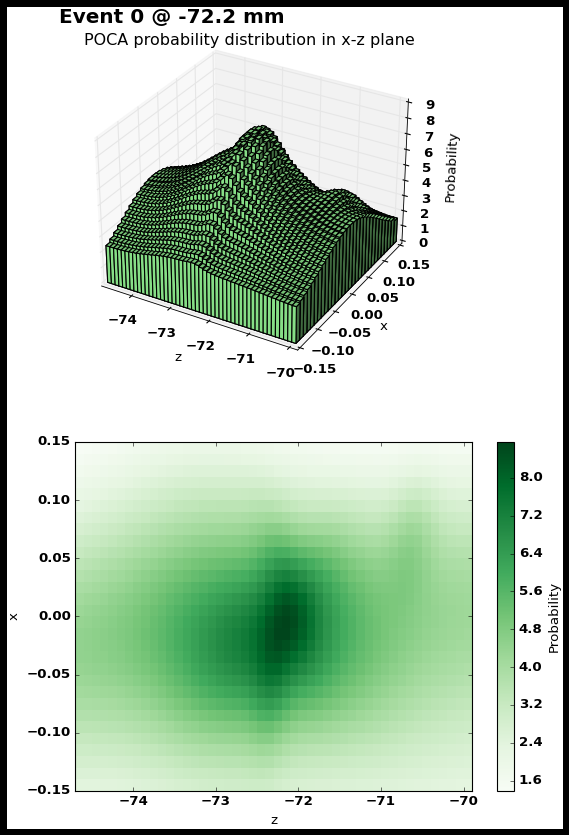

KeyboardInterrupt: 

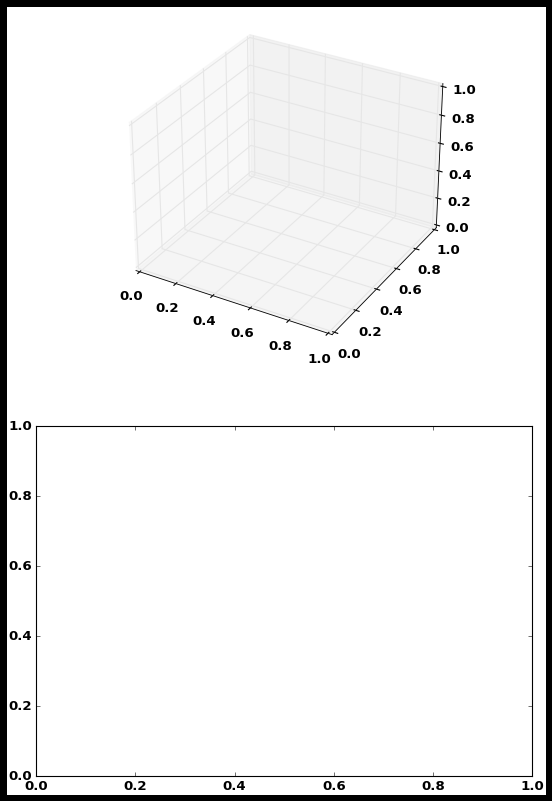

In [34]:
totalCount = 0
for event in range(2):
    
    #assign current input, label, and output for event
    input = inputs[event]
    label = labels[event]
    output = outputs[event]
    
    # Consistent parameters for the calls below
    parameters = {
        "threshold": 1e-2,
        "integral_threshold": .2,
        "min_width": 3
    }
    
    # Compute the "actual" efficencies and things
    ftruth = pv_locations(label, **parameters)
    fcomputed = pv_locations(output, **parameters)
    results = efficiency(label, output, difference=5.0, **parameters)
    
    # Add a line to the final results string (print at end)
    finalmsg += f"Event {event}: {results}\n"
    
    # Make sure bin numbers are integers
    truth = np.around(ftruth).astype(np.int32)
    computed = np.around(fcomputed).astype(np.int32)
    
    # Join arrays and remove any points closer than 5 bins
    # We plot over these "points of interest"
    poi = np.sort(np.concatenate([truth, computed]))
    poi = poi[np.concatenate([[True], np.fabs(np.diff(poi)) > 5])]
    
    print(f"\nEvent {event}:", results)
    
    for index, i in enumerate(poi):
        # Convert to location in z
        center = (i / 10) - 100
        
        with plt.style.context({
            'font.size':12,
            'font.weight':'bold'}):
            
            #specify subplot information (3 subplots)
            
            fig = plt.figure(figsize=(8,12), linewidth=10, edgecolor='k')
            fig.set_facecolor('white')
            ax1 = fig.add_subplot(2, 1, 1, projection='3d')
            ax2 = fig.add_subplot(2, 1, 2)
            
            #initialize grids
            xWidth = 0.01
            zWidth = 0.1
            xSpace = np.arange(-0.15,0.15,xWidth)
            zSpace = np.arange(min_z_vals[totalCount], max_z_vals[totalCount], zWidth)
            zGrid, xGrid = np.meshgrid(zSpace, xSpace)
            yGrid = np.zeros(zGrid.shape)
            pGrid = np.zeros(zGrid.shape)
            
            #iterate through ellipsoids
            for j in range(len(pocas["x"]["major_axis"][event])):
                
                #create three vectors corresponding to major axis and the two minor axes
                major_axis = [pocas["x"]["major_axis"][event][j], 
                              pocas["y"]["major_axis"][event][j],
                              pocas["z"]["major_axis"][event][j]]
                minor_axis1 = [pocas["x"]["minor_axis1"][event][j],
                               pocas["y"]["minor_axis1"][event][j],
                               pocas["z"]["minor_axis1"][event][j]]
                minor_axis2 = [pocas["x"]["minor_axis2"][event][j],
                               pocas["y"]["minor_axis2"][event][j],
                               pocas["z"]["minor_axis2"][event][j]]
                
                p2 = [pocas["x"]["poca"][event][j],
                      pocas["y"]["poca"][event][j],
                      pocas["z"]["poca"][event][j]]
                newProb = updateProb(xGrid, yGrid, zGrid, p2,minor_axis1, minor_axis2, major_axis)
                pGrid = np.add(pGrid, newProb)
                
            ax1.bar3d(zGrid.ravel(), xGrid.ravel(), np.zeros(zGrid.ravel().shape), zWidth, xWidth, pGrid.ravel(),
                     shade = True, color = 'palegreen')
            ax1.set_zlabel('Probability')
            ax1.set_xlabel('z')
            ax1.set_ylabel('x')
            ax1.set_title('POCA probability distribution in x-z plane')
            ax1.set_xlim([min_z_vals[totalCount], max_z_vals[totalCount]])
            ax1.set_ylim([-0.15,0.15])
            ax1.set_anchor('W')
            
            
            #make grids for subplot2
            xSpace2 = np.arange(-0.15,0.15+xWidth,xWidth)
            zSpace2 = np.arange(min_z_vals[totalCount], max_z_vals[totalCount]+zWidth, zWidth)
            zGrid2, xGrid2 = np.meshgrid(zSpace2, xSpace2)
            
            c = ax2.pcolormesh(zGrid2, xGrid2, pGrid, cmap='Greens')
            fig.colorbar(c, ax=ax2, label = 'Probability')
            ax2.set_xlim([min_z_vals[totalCount], max_z_vals[totalCount]])
            ax2.set_ylim([-0.15,0.15])
            ax2.set_xlabel('z')
            ax2.set_ylabel('x')
            ax2.set_anchor('W')
            
            fig.text(0.1,0.9,f"Event {event} @ {center:.1f} mm",
                          fontdict={'size':18, 'weight':'bold'})
            
            totalCount += 1
        
            plt.show()
            